In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [1]:
!pip install mlxtend --user
!pip install lightgbm --user
!pip install xgboost --user
!pip install plotly --user

     |████████████████████████████████| 1.4 MB 23.0 MB/s            
     |████████████████████████████████| 9.8 MB 67.1 MB/s            
     |████████████████████████████████| 297 kB 56.5 MB/s            
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 2.0 MB 24.8 MB/s            
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 200.3 MB 35 kB/s              
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 15.3 MB 23.9 MB/s            
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [2]:
import os
import scipy as sp
import math
import seaborn as sn
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
import warnings
warnings.filterwarnings('ignore')

In [3]:
def rmse(y, y_pred):
    return np.sqrt(np.mean((y - y_pred)**2))

def mae(y, y_pred):
    return np.mean(np.absolute(np.subtract(y, y_pred)))

def r2(y, y_pred):
    return 1 - np.sum((y - y_pred)**2)/np.sum((y - np.mean(y))**2)

def mape(y, y_pred):
    return (np.mean(np.divide(np.absolute(np.subtract(y,y_pred)), y))*100)

def errors(y, y_pred):
    return np.absolute(y - y_pred)

In [4]:
df = pd.read_csv('/mnt/Datasets/merged_df_wet_and_dry_3_20_23.csv').drop(columns = ['Unnamed: 0'])

print(display(df))

,Field_Name,Harvest Year,CO2_kg_per_Ha,Total_Water_Applied_mm,Crop_Protection_Application_Doses,Enter Crop Area (ha),Enter Total Wet Mass Harvested (kg),Enter Dry Finished Yield Mass (kg),Soil_Organic_Matter,Yield_kg_per_Ha,Yield_kg_per_Ha_Dry,N_as_Urea_kg_per_Ha,N_as_Nitrate_kg_per_Ha,N_as_Ammonium_kg_per_Ha,P_as_Phosphorus_kg_per_Ha,P_as_P2O5_kg_per_Ha,K_as_Potassium_kg_per_Ha,K_as_K2O_kg_per_Ha
0,M6I2035,2020,-220.35,350.0,14.0,60.0,182960.0,180200,2.500000,3049.333333,3003.333333,0.0,205.5,0.0,48.0,0.0,48.0,0.0
1,M6I2036,2020,3847.21,350.0,18.0,180.0,643510.0,418990,2.500000,3575.055556,2327.722222,276.0,216.0,0.0,216.0,0.0,216.0,0.0
2,M6I2037,2020,415.52,350.0,13.0,100.0,311620.0,305180,2.500000,3116.200000,3051.800000,138.0,60.0,0.0,60.0,0.0,60.0,0.0
3,M6I2009,2020,724.51,350.0,9.0,90.0,691100.0,335950,2.500000,7678.888889,3732.777778,151.8,18.0,32.6,90.0,5.2,96.0,0.0
4,M6I2010,2020,502.10,350.0,9.0,55.0,426600.0,215560,2.500000,7756.363636,3919.272727,128.8,18.0,32.6,90.0,5.2,90.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,M6I21197,2021,-239.89,350.0,15.0,83.0,338100.0,215140,2.597851,4073.493976,2592.048193,92.0,0.0,0.0,0.0,0.0,0.0,0.0
916,M6I21199,2021,314.80,350.0,17.0,62.0,432120.0,231010,3.120000,6969.677419,3725.967742,184.0,0.0,0.0,0.0,0.0,0.0,0.0
917,M6I21200,2021,-312.82,350.0,19.0,110.0,766660.0,409860,2.930000,6969.636364,3726.000000,92.0,0.0,0.0,0.0,0.0,0.0,0.0
918,M6I21201,2021,485.73,350.0,17.0,120.0,954560.0,480240,3.240000,7954.666667,4002.000000,207.0,0.0,0.0,0.0,0.0,0.0,0.0


None


In [5]:
df['dry_wet_ratio'] = df['Enter Dry Finished Yield Mass (kg)'] / df['Enter Total Wet Mass Harvested (kg)']
print(display(df))
df = df[(df['dry_wet_ratio'] > .2) & (df['dry_wet_ratio'] < .6)].reset_index(drop = True)
print(display(df))
df_season = pd.read_excel('/mnt/Datasets/PC003_consolidated_new (1).xlsx')
df_season['Field Name'] = df_season['Contrato legal'].str[6:]
df_season = df_season[['Field Name', 'Safra']]
df_season = df_season.rename(columns = {'Safra': 'Season', 'Field Name': 'Field_Name'})
df_season = df_season.drop_duplicates().reset_index(drop = True)
df = df.merge(df_season, on = 'Field_Name', how = 'left')

print(display(df))

,Field_Name,Harvest Year,CO2_kg_per_Ha,Total_Water_Applied_mm,Crop_Protection_Application_Doses,Enter Crop Area (ha),Enter Total Wet Mass Harvested (kg),Enter Dry Finished Yield Mass (kg),Soil_Organic_Matter,Yield_kg_per_Ha,Yield_kg_per_Ha_Dry,N_as_Urea_kg_per_Ha,N_as_Nitrate_kg_per_Ha,N_as_Ammonium_kg_per_Ha,P_as_Phosphorus_kg_per_Ha,P_as_P2O5_kg_per_Ha,K_as_Potassium_kg_per_Ha,K_as_K2O_kg_per_Ha,dry_wet_ratio
0,M6I2035,2020,-220.35,350.0,14.0,60.0,182960.0,180200,2.500000,3049.333333,3003.333333,0.0,205.5,0.0,48.0,0.0,48.0,0.0,0.984915
1,M6I2036,2020,3847.21,350.0,18.0,180.0,643510.0,418990,2.500000,3575.055556,2327.722222,276.0,216.0,0.0,216.0,0.0,216.0,0.0,0.651101
2,M6I2037,2020,415.52,350.0,13.0,100.0,311620.0,305180,2.500000,3116.200000,3051.800000,138.0,60.0,0.0,60.0,0.0,60.0,0.0,0.979334
3,M6I2009,2020,724.51,350.0,9.0,90.0,691100.0,335950,2.500000,7678.888889,3732.777778,151.8,18.0,32.6,90.0,5.2,96.0,0.0,0.486109
4,M6I2010,2020,502.10,350.0,9.0,55.0,426600.0,215560,2.500000,7756.363636,3919.272727,128.8,18.0,32.6,90.0,5.2,90.0,0.0,0.505298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,M6I21197,2021,-239.89,350.0,15.0,83.0,338100.0,215140,2.597851,4073.493976,2592.048193,92.0,0.0,0.0,0.0,0.0,0.0,0.0,0.636321
916,M6I21199,2021,314.80,350.0,17.0,62.0,432120.0,231010,3.120000,6969.677419,3725.967742,184.0,0.0,0.0,0.0,0.0,0.0,0.0,0.534597
917,M6I21200,2021,-312.82,350.0,19.0,110.0,766660.0,409860,2.930000,6969.636364,3726.000000,92.0,0.0,0.0,0.0,0.0,0.0,0.0,0.534605
918,M6I21201,2021,485.73,350.0,17.0,120.0,954560.0,480240,3.240000,7954.666667,4002.000000,207.0,0.0,0.0,0.0,0.0,0.0,0.0,0.503101


None


,Field_Name,Harvest Year,CO2_kg_per_Ha,Total_Water_Applied_mm,Crop_Protection_Application_Doses,Enter Crop Area (ha),Enter Total Wet Mass Harvested (kg),Enter Dry Finished Yield Mass (kg),Soil_Organic_Matter,Yield_kg_per_Ha,Yield_kg_per_Ha_Dry,N_as_Urea_kg_per_Ha,N_as_Nitrate_kg_per_Ha,N_as_Ammonium_kg_per_Ha,P_as_Phosphorus_kg_per_Ha,P_as_P2O5_kg_per_Ha,K_as_Potassium_kg_per_Ha,K_as_K2O_kg_per_Ha,dry_wet_ratio
0,M6I2009,2020,724.51,350.0,9.0,90.0,691100.0,335950,2.500000,7678.888889,3732.777778,151.8,18.0,32.60,90.0,5.2,96.0,0.0,0.486109
1,M6I2010,2020,502.10,350.0,9.0,55.0,426600.0,215560,2.500000,7756.363636,3919.272727,128.8,18.0,32.60,90.0,5.2,90.0,0.0,0.505298
2,M6I2011,2020,539.27,350.0,10.0,50.0,411760.0,207120,2.500000,8235.200000,4142.400000,128.8,18.0,32.60,90.0,5.2,102.0,0.0,0.503011
3,M6I20175,2020,814.34,350.0,9.0,25.0,204450.0,103080,2.500000,8178.000000,4123.200000,151.8,24.0,32.05,120.0,2.6,0.0,138.0,0.504182
4,M6I2022,2020,549.46,350.0,10.0,95.0,709680.0,366480,2.500000,7470.315789,3857.684211,128.8,18.0,33.15,90.0,7.8,0.0,102.0,0.516402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,M6I21193,2021,202.99,350.0,18.0,86.0,525080.0,274760,3.346667,6105.581395,3194.883721,115.0,150.0,0.00,0.0,0.0,100.0,0.0,0.523273
842,M6I21199,2021,314.80,350.0,17.0,62.0,432120.0,231010,3.120000,6969.677419,3725.967742,184.0,0.0,0.00,0.0,0.0,0.0,0.0,0.534597
843,M6I21200,2021,-312.82,350.0,19.0,110.0,766660.0,409860,2.930000,6969.636364,3726.000000,92.0,0.0,0.00,0.0,0.0,0.0,0.0,0.534605
844,M6I21201,2021,485.73,350.0,17.0,120.0,954560.0,480240,3.240000,7954.666667,4002.000000,207.0,0.0,0.00,0.0,0.0,0.0,0.0,0.503101


None


,Field_Name,Harvest Year,CO2_kg_per_Ha,Total_Water_Applied_mm,Crop_Protection_Application_Doses,Enter Crop Area (ha),Enter Total Wet Mass Harvested (kg),Enter Dry Finished Yield Mass (kg),Soil_Organic_Matter,Yield_kg_per_Ha,Yield_kg_per_Ha_Dry,N_as_Urea_kg_per_Ha,N_as_Nitrate_kg_per_Ha,N_as_Ammonium_kg_per_Ha,P_as_Phosphorus_kg_per_Ha,P_as_P2O5_kg_per_Ha,K_as_Potassium_kg_per_Ha,K_as_K2O_kg_per_Ha,dry_wet_ratio,Season
0,M6I2009,2020,724.51,350.0,9.0,90.0,691100.0,335950,2.500000,7678.888889,3732.777778,151.8,18.0,32.60,90.0,5.2,96.0,0.0,0.486109,WINTER
1,M6I2010,2020,502.10,350.0,9.0,55.0,426600.0,215560,2.500000,7756.363636,3919.272727,128.8,18.0,32.60,90.0,5.2,90.0,0.0,0.505298,WINTER
2,M6I2011,2020,539.27,350.0,10.0,50.0,411760.0,207120,2.500000,8235.200000,4142.400000,128.8,18.0,32.60,90.0,5.2,102.0,0.0,0.503011,WINTER
3,M6I20175,2020,814.34,350.0,9.0,25.0,204450.0,103080,2.500000,8178.000000,4123.200000,151.8,24.0,32.05,120.0,2.6,0.0,138.0,0.504182,WINTER
4,M6I2022,2020,549.46,350.0,10.0,95.0,709680.0,366480,2.500000,7470.315789,3857.684211,128.8,18.0,33.15,90.0,7.8,0.0,102.0,0.516402,WINTER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,M6I21193,2021,202.99,350.0,18.0,86.0,525080.0,274760,3.346667,6105.581395,3194.883721,115.0,150.0,0.00,0.0,0.0,100.0,0.0,0.523273,WINTER
842,M6I21199,2021,314.80,350.0,17.0,62.0,432120.0,231010,3.120000,6969.677419,3725.967742,184.0,0.0,0.00,0.0,0.0,0.0,0.0,0.534597,WINTER
843,M6I21200,2021,-312.82,350.0,19.0,110.0,766660.0,409860,2.930000,6969.636364,3726.000000,92.0,0.0,0.00,0.0,0.0,0.0,0.0,0.534605,WINTER
844,M6I21201,2021,485.73,350.0,17.0,120.0,954560.0,480240,3.240000,7954.666667,4002.000000,207.0,0.0,0.00,0.0,0.0,0.0,0.0,0.503101,WINTER


None


In [7]:
df_summer = df[df['Season'] == 'SUMMER'].reset_index(drop = True)
print(display(df_summer))

,Field_Name,Harvest Year,CO2_kg_per_Ha,Total_Water_Applied_mm,Crop_Protection_Application_Doses,Enter Crop Area (ha),Enter Total Wet Mass Harvested (kg),Enter Dry Finished Yield Mass (kg),Soil_Organic_Matter,Yield_kg_per_Ha,Yield_kg_per_Ha_Dry,N_as_Urea_kg_per_Ha,N_as_Nitrate_kg_per_Ha,N_as_Ammonium_kg_per_Ha,P_as_Phosphorus_kg_per_Ha,P_as_P2O5_kg_per_Ha,K_as_Potassium_kg_per_Ha,K_as_K2O_kg_per_Ha,dry_wet_ratio,Season
0,M6V2017,2020,-246.74,450.0,14.0,75.6,573520.0,309700,3.690000,7586.243386,4096.560847,170.2,0.00,0.00,0.0,0.0,0.0,0.0,0.539999,SUMMER
1,M6V2018,2020,219.02,450.0,20.0,52.8,380420.0,205430,3.380000,7204.924242,3890.719697,179.4,0.00,0.00,0.0,0.0,0.0,90.0,0.540008,SUMMER
2,M6V2039,2020,860.73,450.0,18.0,45.0,537370.0,240740,2.681429,11941.555556,5349.777778,0.0,74.25,74.25,0.0,0.0,0.0,0.0,0.447997,SUMMER
3,M6V2040,2020,799.98,450.0,17.0,45.0,480320.0,232330,2.681429,10673.777778,5162.888889,0.0,74.25,74.25,0.0,0.0,0.0,0.0,0.483698,SUMMER
4,M6V2074,2020,-1118.18,450.0,15.0,70.0,811050.0,358160,3.320000,11586.428571,5116.571429,0.0,23.00,0.00,75.9,0.0,0.0,0.0,0.441600,SUMMER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,M6V2195,2021,438.65,450.0,15.0,25.0,186400.0,100360,2.100000,7456.000000,4014.400000,92.0,36.00,0.00,126.0,0.0,150.0,0.0,0.538412,SUMMER
395,M6V2196,2021,848.98,450.0,15.0,37.5,288490.0,167760,2.500000,7693.066667,4473.600000,165.6,36.00,0.00,63.0,0.0,54.0,96.0,0.581511,SUMMER
396,M8V2160,2021,449.67,450.0,16.0,65.0,584540.0,298180,2.690000,8992.923077,4587.384615,128.8,0.00,24.20,0.0,114.4,0.0,78.0,0.510111,SUMMER
397,M8V2163,2021,-427.99,450.0,15.0,119.0,802860.0,401350,3.750000,6746.722689,3372.689076,128.8,0.00,24.20,0.0,114.4,0.0,81.0,0.499900,SUMMER


None


In [52]:
#########################
### Yield Pred Summer ###
#########################

#Yeo-Johnson Scaling
df_summer = df_summer[['Crop_Protection_Application_Doses', 'Yield_kg_per_Ha', 'Soil_Organic_Matter', \
                       'N_as_Urea_kg_per_Ha', 'N_as_Nitrate_kg_per_Ha', 'N_as_Ammonium_kg_per_Ha', 'P_as_Phosphorus_kg_per_Ha', 'P_as_P2O5_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'K_as_K2O_kg_per_Ha']]

print(display(df_summer))

# #filter outliers
# df_summer = df_summer[(df_summer['Yield_kg_per_Ha'] > df_summer['Yield_kg_per_Ha'].quantile(.05)) \
#                                                                & (df_summer['Yield_kg_per_Ha'] < df_summer['Yield_kg_per_Ha'].quantile(.95))].reset_index(drop = True)

#train/test split
train_Yield_kg_per_ha, test_Yield_kg_per_ha = train_test_split(df_summer, test_size = 0.2, random_state = 60)

#x values
X_train_Yield_kg_per_ha = train_Yield_kg_per_ha.drop(columns = ['Yield_kg_per_Ha'])
X_test_Yield_kg_per_ha = test_Yield_kg_per_ha.drop(columns = ['Yield_kg_per_Ha'])

standard_scaler_X = StandardScaler().fit(X_train_Yield_kg_per_ha)
X_train_Yield_kg_per_ha = standard_scaler_X.transform(X_train_Yield_kg_per_ha)

power_transform_X = PowerTransformer(standardize = True).fit(X_train_Yield_kg_per_ha)
X_train_Yield_kg_per_ha = power_transform_X.transform(X_train_Yield_kg_per_ha)

X_test_Yield_kg_per_ha = standard_scaler_X.transform(X_test_Yield_kg_per_ha)
X_test_Yield_kg_per_ha = power_transform_X.transform(X_test_Yield_kg_per_ha)

#y_values
y_train_Yield_kg_per_ha = np.array(train_Yield_kg_per_ha['Yield_kg_per_Ha']).reshape(-1, 1)

mean_Yield_kg_per_ha = y_train_Yield_kg_per_ha.mean()

y_test_Yield_kg_per_ha = np.array(test_Yield_kg_per_ha['Yield_kg_per_Ha']).reshape(-1, 1)

standard_scaler_y = StandardScaler().fit(np.array(y_train_Yield_kg_per_ha))

y_train_Yield_kg_per_ha = standard_scaler_y.transform(y_train_Yield_kg_per_ha)

power_transform_y = PowerTransformer(standardize = False).fit(y_train_Yield_kg_per_ha)

y_train_Yield_kg_per_ha = power_transform_y.transform(y_train_Yield_kg_per_ha)

y_test_Yield_kg_per_ha = standard_scaler_y.transform(y_test_Yield_kg_per_ha)

y_test_Yield_kg_per_ha = power_transform_y.transform(y_test_Yield_kg_per_ha)

,Crop_Protection_Application_Doses,Yield_kg_per_Ha,Soil_Organic_Matter,N_as_Urea_kg_per_Ha,N_as_Nitrate_kg_per_Ha,N_as_Ammonium_kg_per_Ha,P_as_Phosphorus_kg_per_Ha,P_as_P2O5_kg_per_Ha,K_as_Potassium_kg_per_Ha
0,14.0,7586.243386,3.690000,170.2,0.00,0.00,0.0,0.0,0.0
1,20.0,7204.924242,3.380000,179.4,0.00,0.00,0.0,0.0,0.0
2,18.0,11941.555556,2.681429,0.0,74.25,74.25,0.0,0.0,0.0
3,17.0,10673.777778,2.681429,0.0,74.25,74.25,0.0,0.0,0.0
4,15.0,11586.428571,3.320000,0.0,23.00,0.00,75.9,0.0,0.0
...,...,...,...,...,...,...,...,...,...
394,15.0,7456.000000,2.100000,92.0,36.00,0.00,126.0,0.0,150.0
395,15.0,7693.066667,2.500000,165.6,36.00,0.00,63.0,0.0,54.0
396,16.0,8992.923077,2.690000,128.8,0.00,24.20,0.0,114.4,0.0
397,15.0,6746.722689,3.750000,128.8,0.00,24.20,0.0,114.4,0.0


None


In [54]:
print(train_Yield_kg_per_ha.shape)
print(X_train_Yield_kg_per_ha.shape)
print(y_train_Yield_kg_per_ha.shape)


(319, 9)
(319, 8)
(319, 1)


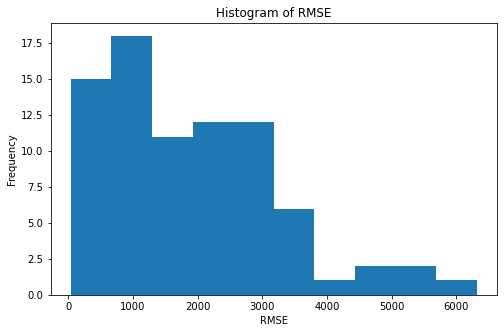

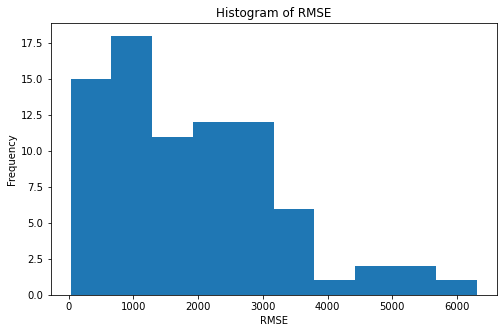

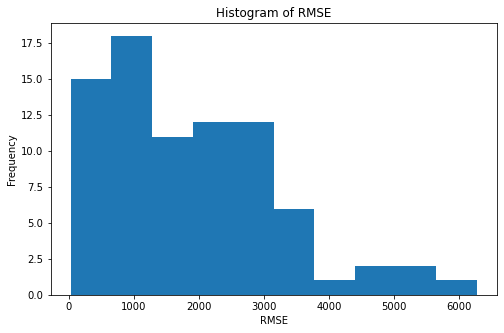

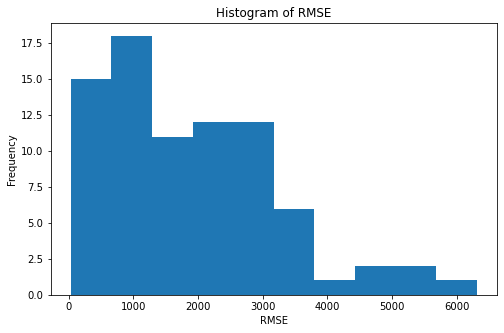

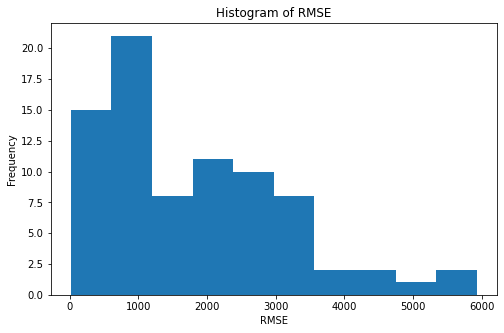

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75


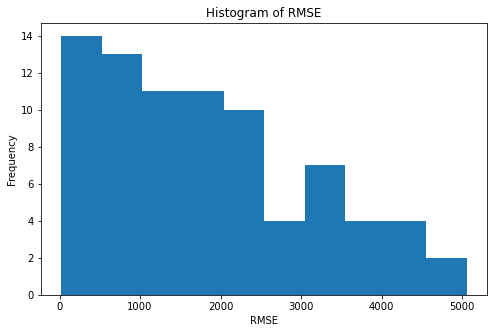

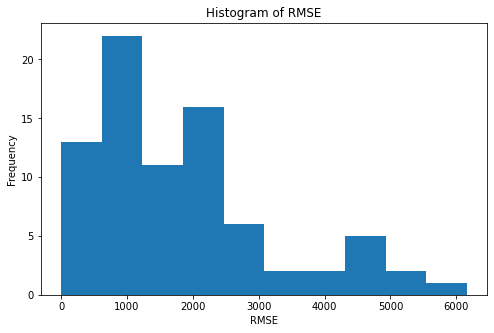

[15:33:04] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


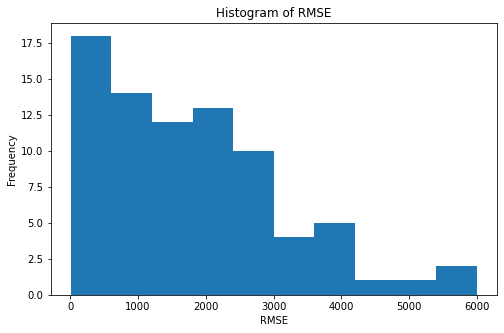

In [55]:
####Initialize K fold Cross validation
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 42)

#####Grid Space for Lasso, Ridge, ElasticNet
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

####Model Building

model_names = ['OLS', 'Lasso', 'Ridge', 'ElasticNet', 'SVR', 'Lightgbm', 'GBR', 'XGBoost']
models = [linear_model.LinearRegression(), \
            LassoCV(max_iter = int(1e7), alphas = alphas2, random_state = 42, cv = kfolds), \
                  RidgeCV(alphas = alphas_alt, cv = kfolds), \
                  ElasticNetCV(max_iter = int(1e7), alphas = e_alphas, cv = kfolds, l1_ratio = e_l1ratio), \
                  SVR(C = 20, epsilon = 0.008, gamma = 0.0003), \
                  LGBMRegressor(objective='regression', num_leaves = 4, learning_rate = 0.01, n_estimators = 5000, max_bin = 200, bagging_fraction = 0.75, \
                                bagging_freq = 5, bagging_seed = 7, feature_fraction = 0.2, feature_fraction_seed = 7, verbose = -1), \
                  GradientBoostingRegressor(n_estimators = 5000, learning_rate = 0.05, max_depth = 4, max_features = 'sqrt', min_samples_leaf = 15, \
                                            min_samples_split = 10, loss = 'huber', random_state = 42), \
                  XGBRegressor(learning_rate = 0.005, n_estimators = 10000, max_depth = 3, min_child_weight = 0, gamma = 0, subsample = 0.7, \
                               colsample_bytree = 0.7, objective = 'reg:linear', nthread = -1, scale_pos_weight = 1, seed = 27, reg_alpha = 0.00006)
         ]

fitted_models = []
Test_MAE_models = []
Test_RMSE_models = []
Test_R2_models = []
Test_mape_models = []

for model in models:
    fitted_models.append(model.fit(X_train_Yield_kg_per_ha, y_train_Yield_kg_per_ha))
    inv_transform_y_actuals = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(y_test_Yield_kg_per_ha).reshape(-1, 1))
    inv_transformed_preds = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(fitted_models[models.index(model)].predict(X_test_Yield_kg_per_ha).reshape(-1,1)))                                             
    Test_MAE_models.append(mae(inv_transform_y_actuals, inv_transformed_preds))
    Test_RMSE_models.append(rmse(inv_transform_y_actuals, inv_transformed_preds))
    Test_R2_models.append(r2(inv_transform_y_actuals, inv_transformed_preds))
    Test_mape_models.append(mape(inv_transform_y_actuals, inv_transformed_preds))
    plt.figure(figsize = (8,5))
    plt.hist(np.sqrt((inv_transform_y_actuals - inv_transformed_preds)**2))
    plt.xlabel('RMSE')
    plt.ylabel('Frequency')
    plt.title('Histogram of RMSE')
    plt.show()

OLS
MAE on test data: 1881.8461944820033
RMSE on test data: 2318.0350593790226
R squared on test data: -0.11071401655540458
MAPE on test data: 38.58696057367146


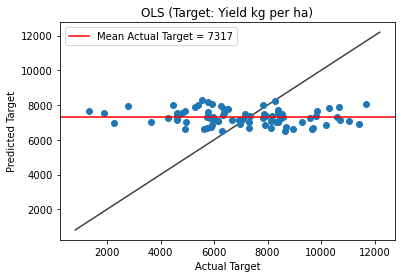

Lasso
MAE on test data: 1879.9441738350258
RMSE on test data: 2315.3515034202724
R squared on test data: -0.10814378978510408
MAPE on test data: 38.53968875390974


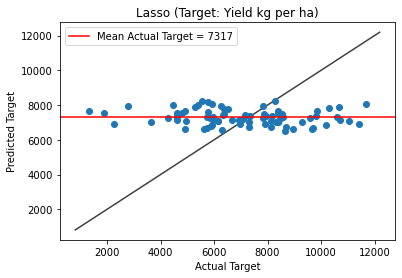

Ridge
MAE on test data: 1875.3647583754432
RMSE on test data: 2309.6767073054025
R squared on test data: -0.10271845052561202
MAPE on test data: 38.449072419703555


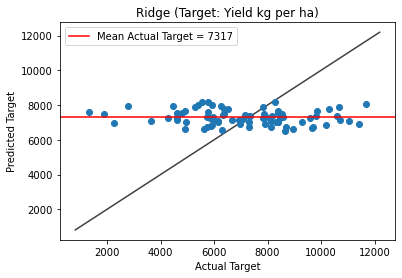

ElasticNet
MAE on test data: 1880.1821515143572
RMSE on test data: 2315.6862947534432
R squared on test data: -0.10846428000749775
MAPE on test data: 38.545605307789145


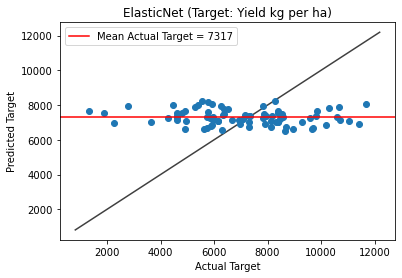

SVR
MAE on test data: 1836.6154651912852
RMSE on test data: 2271.0384635427195
R squared on test data: -0.0661326200048844
MAPE on test data: 37.58806517362433


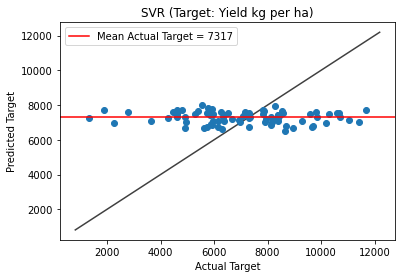

Lightgbm
MAE on test data: 1813.1886347847474
RMSE on test data: 2235.2882948932565
R squared on test data: -0.0328311789933835
MAPE on test data: 34.22641717675631


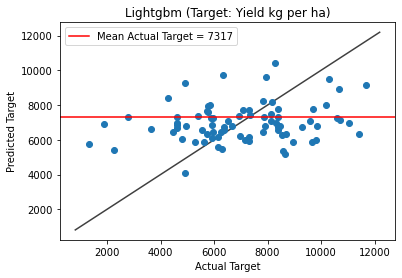

GBR
MAE on test data: 1822.7811623041794
RMSE on test data: 2285.1224699948784
R squared on test data: -0.07939701735786686
MAPE on test data: 31.52209914072388


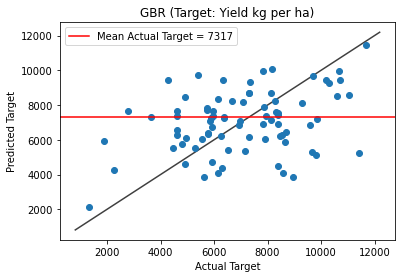

XGBoost
MAE on test data: 1784.5390262306223
RMSE on test data: 2223.3038139696937
R squared on test data: -0.02178583557136471
MAPE on test data: 30.992666172659067


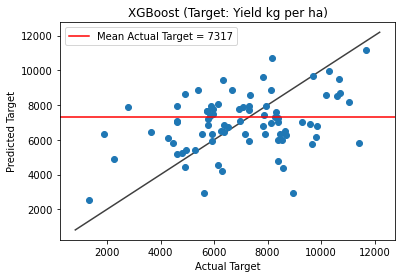

In [56]:
for model_name in model_names:
    print(model_name)
    print('MAE on test data: ' + str(Test_MAE_models[model_names.index(model_name)]))
    print('RMSE on test data: ' + str(Test_RMSE_models[model_names.index(model_name)]))
    print('R squared on test data: ' + str(Test_R2_models[model_names.index(model_name)]))
    print('MAPE on test data: ' + str(Test_mape_models[model_names.index(model_name)]))
    inv_transformed_y_actuals = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(y_test_Yield_kg_per_ha).reshape(-1, 1))
    inv_transformed_preds = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(fitted_models[model_names.index(model_name)].predict(X_test_Yield_kg_per_ha).reshape(-1,1)))
    fig, ax = plt.subplots()
    ax.axhline(y=mean_Yield_kg_per_ha, color='r', linestyle='-', label = 'Mean Actual Target = ' + str(int(mean_Yield_kg_per_ha)))
    ax.scatter(inv_transformed_y_actuals, inv_transformed_preds)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('Actual Target')
    plt.ylabel('Predicted Target')
    plt.title(model_name + ' (Target: Yield kg per ha)')
    plt.legend()
    plt.show()

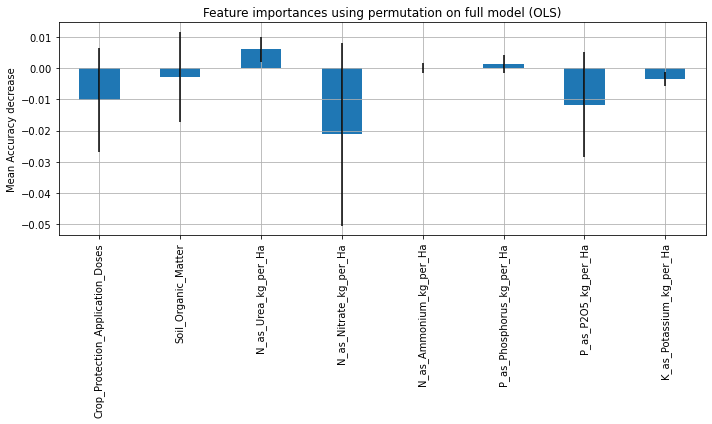

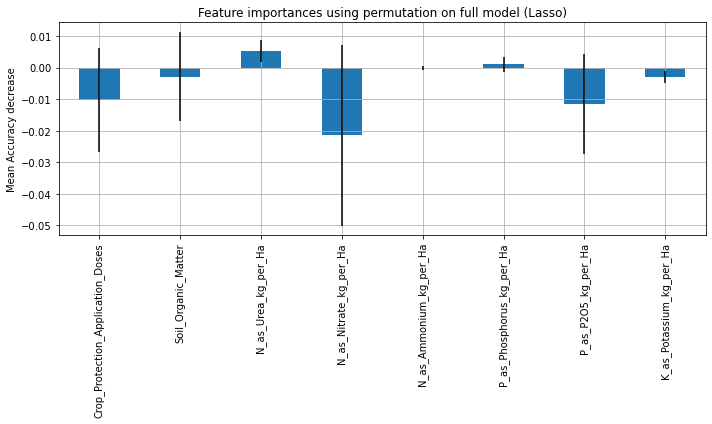

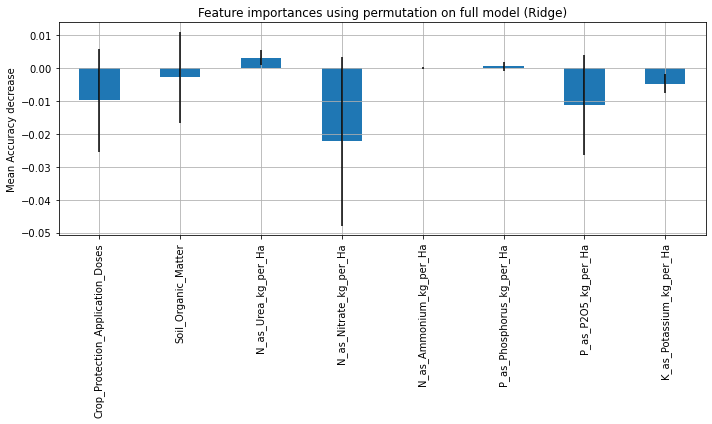

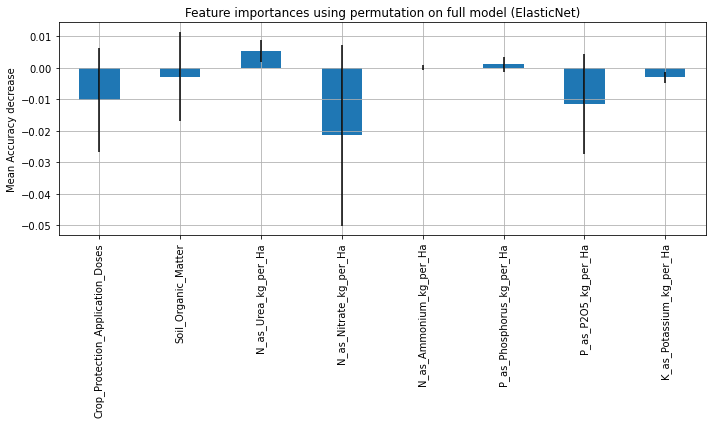

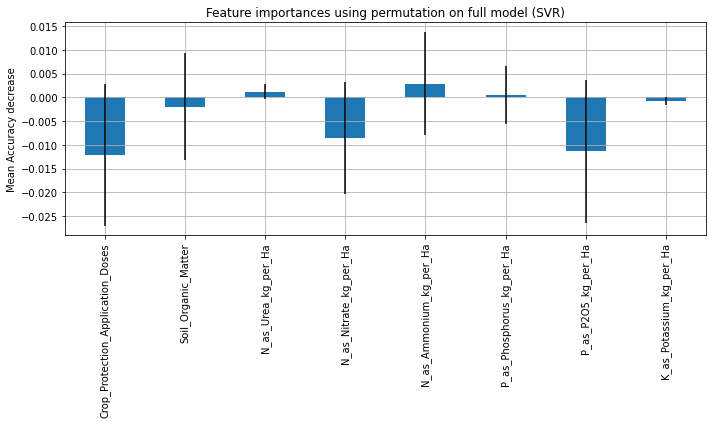

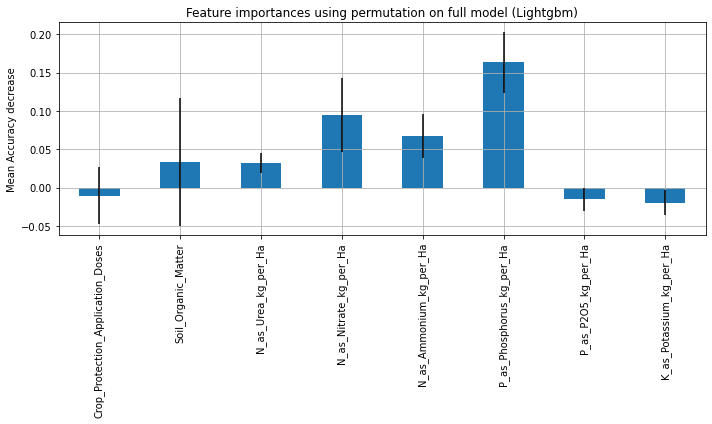

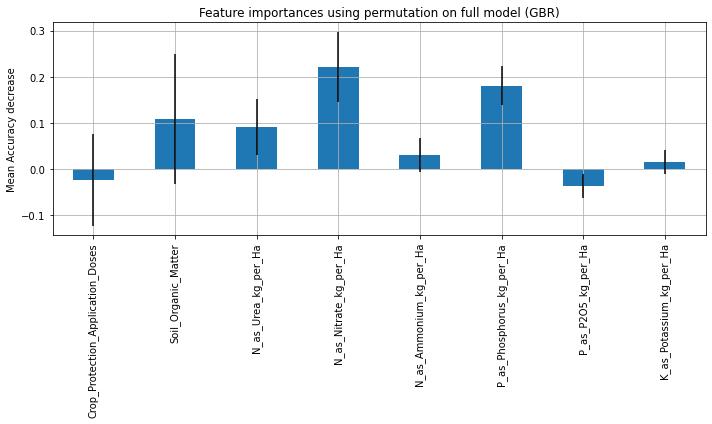

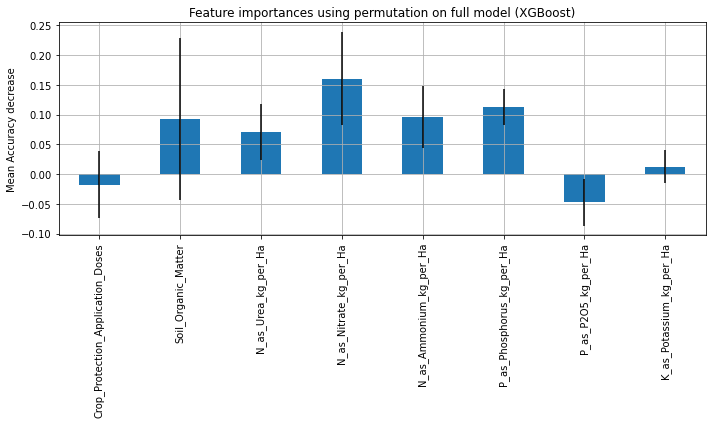

In [57]:
from sklearn.inspection import permutation_importance

for i in range(len(fitted_models)):
    feature_names = train_Yield_kg_per_ha.drop(columns = ['Yield_kg_per_Ha']).columns

    result = permutation_importance(
        fitted_models[i], X_test_Yield_kg_per_ha, y_test_Yield_kg_per_ha, n_repeats=10, random_state=42, n_jobs=2
    )

    model_importances = pd.Series(result.importances_mean, index = feature_names)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    model_importances.plot.bar(yerr = result.importances_std, ax = ax)
    ax.set_title("Feature importances using permutation on full model (" + str(model_names[i]) + ')')
    ax.set_ylabel("Mean Accuracy decrease")
    plt.grid()
    fig.tight_layout()
    plt.show()

In [8]:
df_winter = df[df['Season'] == 'WINTER'].reset_index(drop = True)

In [6]:
#########################
### Yield Pred Winter ###
#########################

#Yeo-Johnson Scaling
df_winter = df_winter[['Crop_Protection_Application_Doses', 'Yield_kg_per_Ha', 'Soil_Organic_Matter', \
                       'N_as_Urea_kg_per_Ha', 'N_as_Nitrate_kg_per_Ha', 'N_as_Ammonium_kg_per_Ha', 'P_as_Phosphorus_kg_per_Ha', 'P_as_P2O5_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'K_as_K2O_kg_per_Ha']]

print(display(df_winter))

# #filter outliers
# df_summer = df_summer[(df_summer['Yield_kg_per_Ha'] > df_summer['Yield_kg_per_Ha'].quantile(.05)) \
#                                                                & (df_summer['Yield_kg_per_Ha'] < df_summer['Yield_kg_per_Ha'].quantile(.95))].reset_index(drop = True)

#train/test split
train_Yield_kg_per_ha, test_Yield_kg_per_ha = train_test_split(df_winter, test_size = 0.2, random_state = 60)

#x values
X_train_Yield_kg_per_ha = train_Yield_kg_per_ha.drop(columns = ['Yield_kg_per_Ha'])
X_test_Yield_kg_per_ha = test_Yield_kg_per_ha.drop(columns = ['Yield_kg_per_Ha'])

standard_scaler_X = StandardScaler().fit(X_train_Yield_kg_per_ha)
X_train_Yield_kg_per_ha = standard_scaler_X.transform(X_train_Yield_kg_per_ha)

power_transform_X = PowerTransformer(standardize = True).fit(X_train_Yield_kg_per_ha)
X_train_Yield_kg_per_ha = power_transform_X.transform(X_train_Yield_kg_per_ha)

X_test_Yield_kg_per_ha = standard_scaler_X.transform(X_test_Yield_kg_per_ha)
X_test_Yield_kg_per_ha = power_transform_X.transform(X_test_Yield_kg_per_ha)

#y_values
y_train_Yield_kg_per_ha = np.array(train_Yield_kg_per_ha['Yield_kg_per_Ha']).reshape(-1, 1)

mean_Yield_kg_per_ha = y_train_Yield_kg_per_ha.mean()

y_test_Yield_kg_per_ha = np.array(test_Yield_kg_per_ha['Yield_kg_per_Ha']).reshape(-1, 1)

standard_scaler_y = StandardScaler().fit(np.array(y_train_Yield_kg_per_ha))

y_train_Yield_kg_per_ha = standard_scaler_y.transform(y_train_Yield_kg_per_ha)

power_transform_y = PowerTransformer(standardize = False).fit(y_train_Yield_kg_per_ha)

y_train_Yield_kg_per_ha = power_transform_y.transform(y_train_Yield_kg_per_ha)

y_test_Yield_kg_per_ha = standard_scaler_y.transform(y_test_Yield_kg_per_ha)

y_test_Yield_kg_per_ha = power_transform_y.transform(y_test_Yield_kg_per_ha)

NameError: name 'df_winter' is not defined

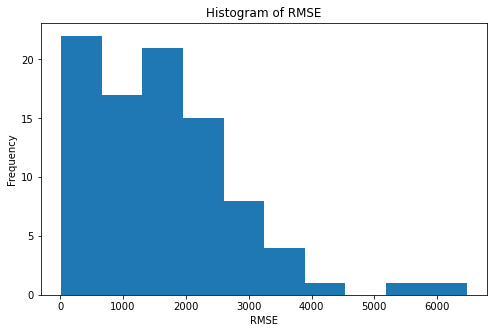

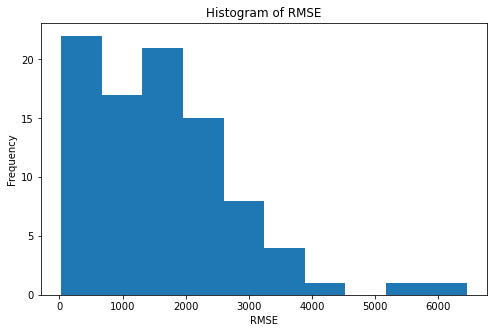

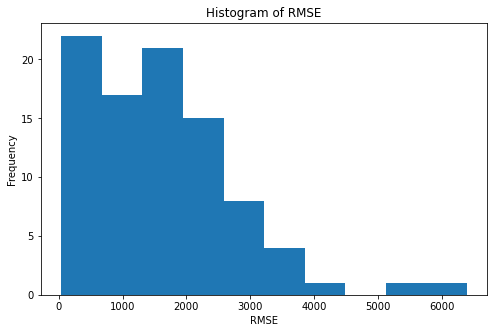

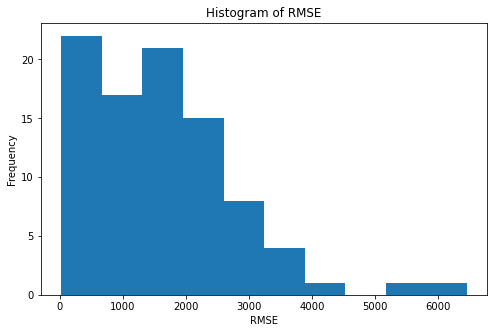

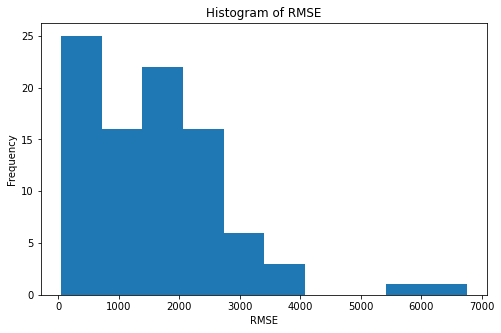

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75


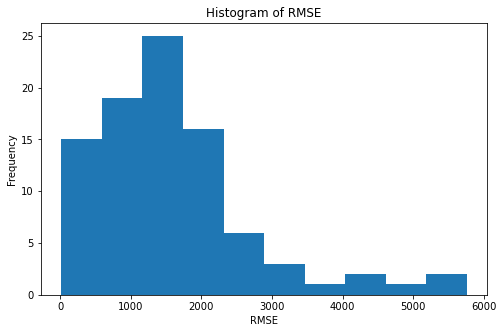

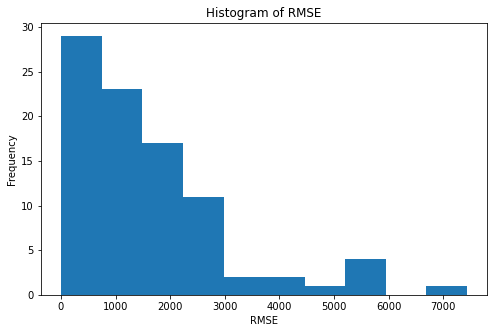

[16:00:42] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


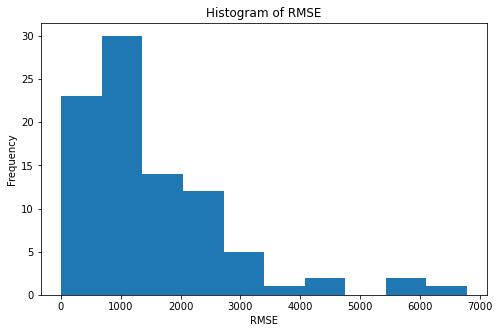

In [60]:
####Initialize K fold Cross validation
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 42)

#####Grid Space for Lasso, Ridge, ElasticNet
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

####Model Building

model_names = ['OLS', 'Lasso', 'Ridge', 'ElasticNet', 'SVR', 'Lightgbm', 'GBR', 'XGBoost']
models = [linear_model.LinearRegression(), \
            LassoCV(max_iter = int(1e7), alphas = alphas2, random_state = 42, cv = kfolds), \
                  RidgeCV(alphas = alphas_alt, cv = kfolds), \
                  ElasticNetCV(max_iter = int(1e7), alphas = e_alphas, cv = kfolds, l1_ratio = e_l1ratio), \
                  SVR(C = 20, epsilon = 0.008, gamma = 0.0003), \
                  LGBMRegressor(objective='regression', num_leaves = 4, learning_rate = 0.01, n_estimators = 5000, max_bin = 200, bagging_fraction = 0.75, \
                                bagging_freq = 5, bagging_seed = 7, feature_fraction = 0.2, feature_fraction_seed = 7, verbose = -1), \
                  GradientBoostingRegressor(n_estimators = 5000, learning_rate = 0.05, max_depth = 4, max_features = 'sqrt', min_samples_leaf = 15, \
                                            min_samples_split = 10, loss = 'huber', random_state = 42), \
                  XGBRegressor(learning_rate = 0.005, n_estimators = 10000, max_depth = 3, min_child_weight = 0, gamma = 0, subsample = 0.7, \
                               colsample_bytree = 0.7, objective = 'reg:linear', nthread = -1, scale_pos_weight = 1, seed = 27, reg_alpha = 0.00006)
         ]

fitted_models = []
Test_MAE_models = []
Test_RMSE_models = []
Test_R2_models = []
Test_mape_models = []

for model in models:
    fitted_models.append(model.fit(X_train_Yield_kg_per_ha, y_train_Yield_kg_per_ha))
    inv_transform_y_actuals = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(y_test_Yield_kg_per_ha).reshape(-1, 1))
    inv_transformed_preds = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(fitted_models[models.index(model)].predict(X_test_Yield_kg_per_ha).reshape(-1,1)))                                             
    Test_MAE_models.append(mae(inv_transform_y_actuals, inv_transformed_preds))
    Test_RMSE_models.append(rmse(inv_transform_y_actuals, inv_transformed_preds))
    Test_R2_models.append(r2(inv_transform_y_actuals, inv_transformed_preds))
    Test_mape_models.append(mape(inv_transform_y_actuals, inv_transformed_preds))
    plt.figure(figsize = (8,5))
    plt.hist(np.sqrt((inv_transform_y_actuals - inv_transformed_preds)**2))
    plt.xlabel('RMSE')
    plt.ylabel('Frequency')
    plt.title('Histogram of RMSE')
    plt.show()

OLS
MAE on test data: 1610.8462445304292
RMSE on test data: 1991.7977654697465
R squared on test data: -0.0795616427127166
MAPE on test data: 31.82398442928679


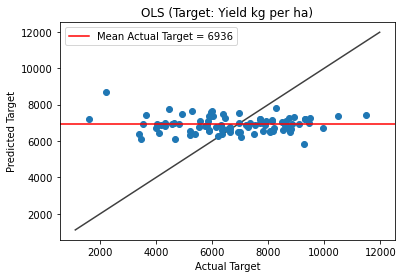

Lasso
MAE on test data: 1610.5496364861838
RMSE on test data: 1991.005600839272
R squared on test data: -0.07870310124406665
MAPE on test data: 31.820022257554687


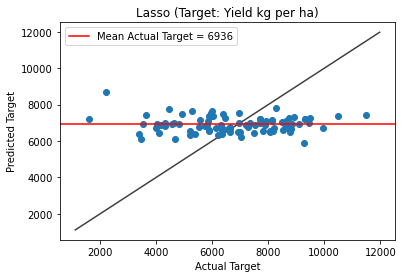

Ridge
MAE on test data: 1609.3652931721247
RMSE on test data: 1986.9313273164785
R squared on test data: -0.07429283266277698
MAPE on test data: 31.782165478362263


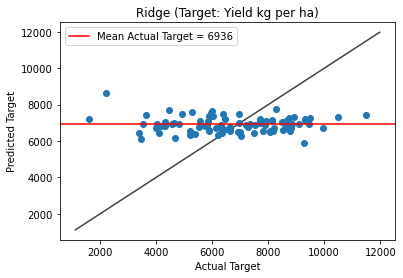

ElasticNet
MAE on test data: 1610.5869164672256
RMSE on test data: 1991.1034517484259
R squared on test data: -0.07880913276188428
MAPE on test data: 31.820521241468068


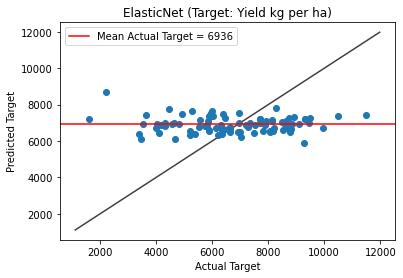

SVR
MAE on test data: 1615.8968644382317
RMSE on test data: 2005.4477497393275
R squared on test data: -0.09440902663674122
MAPE on test data: 32.078444652396485


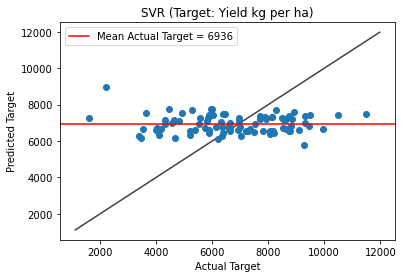

Lightgbm
MAE on test data: 1577.2339668670609
RMSE on test data: 1934.4729708692134
R squared on test data: -0.018315362886369257
MAPE on test data: 29.90234826728545


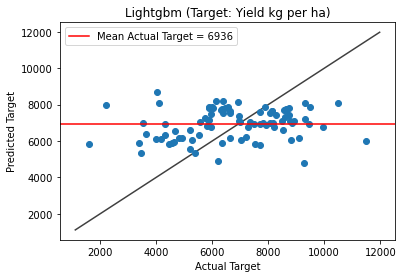

GBR
MAE on test data: 1590.671109693832
RMSE on test data: 2170.668913834645
R squared on test data: -0.2821656490956932
MAPE on test data: 30.207365238349578


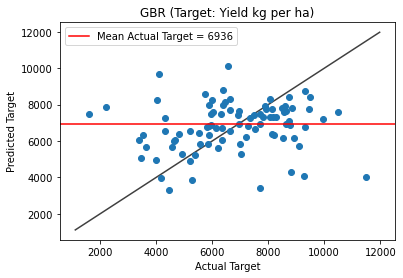

XGBoost
MAE on test data: 1520.294846764314
RMSE on test data: 1993.5440631947797
R squared on test data: -0.08145547200458458
MAPE on test data: 28.879218040670217


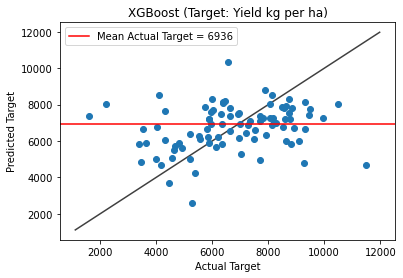

In [61]:
for model_name in model_names:
    print(model_name)
    print('MAE on test data: ' + str(Test_MAE_models[model_names.index(model_name)]))
    print('RMSE on test data: ' + str(Test_RMSE_models[model_names.index(model_name)]))
    print('R squared on test data: ' + str(Test_R2_models[model_names.index(model_name)]))
    print('MAPE on test data: ' + str(Test_mape_models[model_names.index(model_name)]))
    inv_transformed_y_actuals = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(y_test_Yield_kg_per_ha).reshape(-1, 1))
    inv_transformed_preds = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(fitted_models[model_names.index(model_name)].predict(X_test_Yield_kg_per_ha).reshape(-1,1)))
    fig, ax = plt.subplots()
    ax.axhline(y=mean_Yield_kg_per_ha, color='r', linestyle='-', label = 'Mean Actual Target = ' + str(int(mean_Yield_kg_per_ha)))
    ax.scatter(inv_transformed_y_actuals, inv_transformed_preds)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('Actual Target')
    plt.ylabel('Predicted Target')
    plt.title(model_name + ' (Target: Yield kg per ha)')
    plt.legend()
    plt.show()

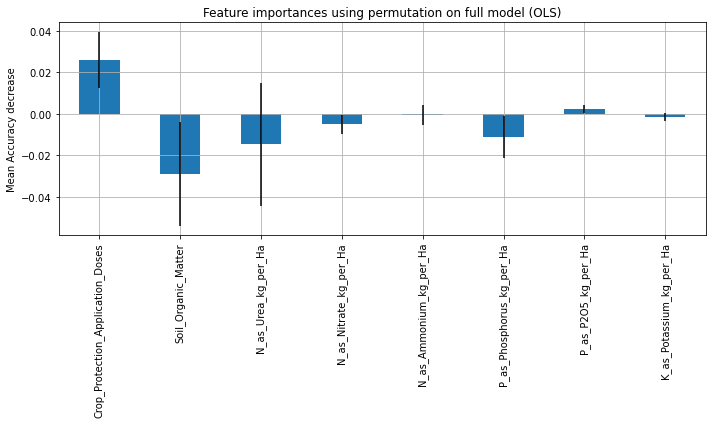

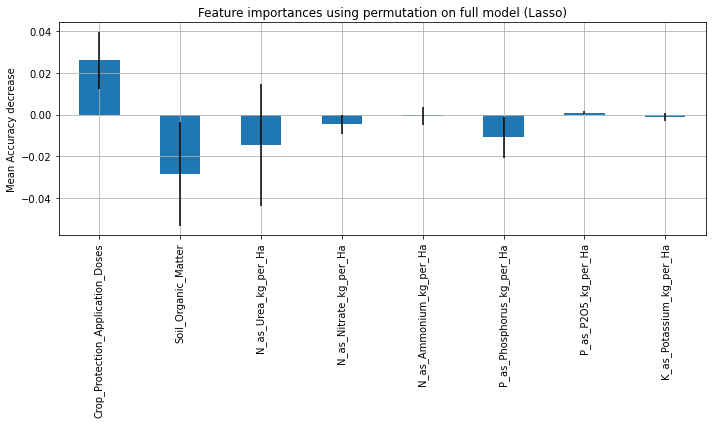

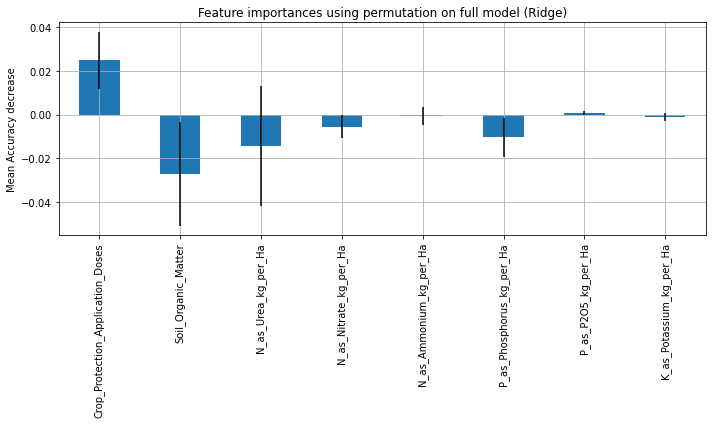

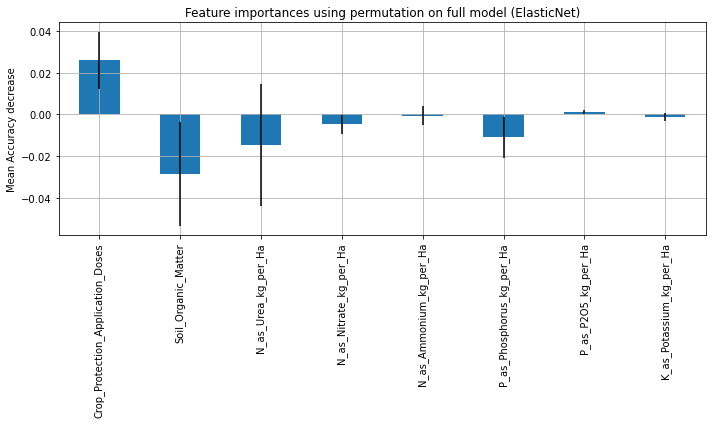

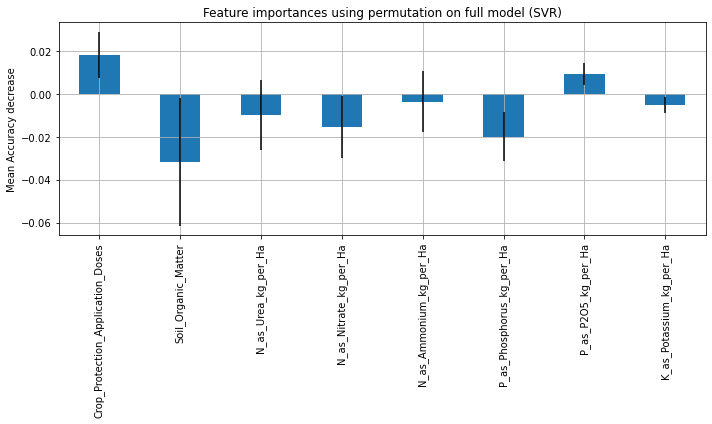

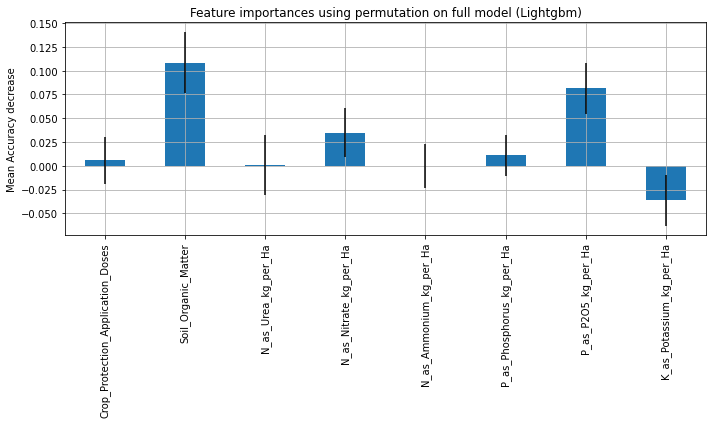

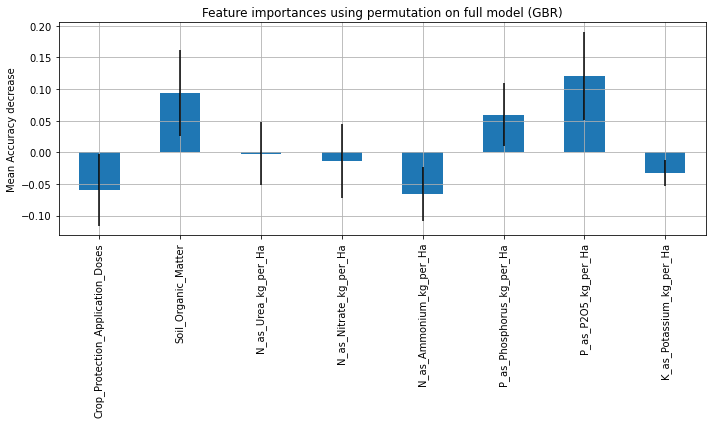

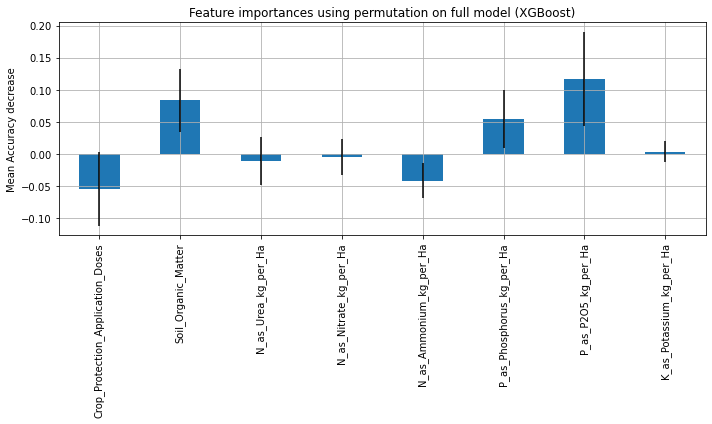

In [62]:
from sklearn.inspection import permutation_importance

for i in range(len(fitted_models)):
    feature_names = train_Yield_kg_per_ha.drop(columns = ['Yield_kg_per_Ha']).columns

    result = permutation_importance(
        fitted_models[i], X_test_Yield_kg_per_ha, y_test_Yield_kg_per_ha, n_repeats=10, random_state=42, n_jobs=2
    )

    model_importances = pd.Series(result.importances_mean, index = feature_names)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    model_importances.plot.bar(yerr = result.importances_std, ax = ax)
    ax.set_title("Feature importances using permutation on full model (" + str(model_names[i]) + ')')
    ax.set_ylabel("Mean Accuracy decrease")
    plt.grid()
    fig.tight_layout()
    plt.show()

In [6]:
#######################################
### Yield Pred Summer SOM cluster 0 ###
#######################################

df_summer = df[df['Season'] == 'SUMMER'].reset_index(drop = True)

#Yeo-Johnson Scaling
df_summer = df_summer[['Crop_Protection_Application_Doses', 'Yield_kg_per_Ha', 'Soil_Organic_Matter', \
                       'N_as_Urea_kg_per_Ha', 'N_as_Nitrate_kg_per_Ha', 'N_as_Ammonium_kg_per_Ha', 'P_as_Phosphorus_kg_per_Ha', 'P_as_P2O5_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'K_as_K2O_kg_per_Ha']]

kmeans = KMeans(n_clusters = 2)
kmeans.fit(df_summer['Soil_Organic_Matter'].values.reshape(-1,1))
df_summer['cluster'] = kmeans.labels_

df_summer_SOM_cluster_0 = df_summer[df_summer['cluster'] == 0].reset_index(drop = True)
df_summer_SOM_cluster_0 = df_summer_SOM_cluster_0.drop(columns = ['cluster'])

df_summer_SOM_cluster_0 = df_summer_SOM_cluster_0[(df_summer_SOM_cluster_0['Yield_kg_per_Ha'] > df_summer_SOM_cluster_0['Yield_kg_per_Ha'].quantile(.05)) \
                                                               & (df_summer_SOM_cluster_0['Yield_kg_per_Ha'] < df_summer_SOM_cluster_0['Yield_kg_per_Ha'].quantile(.95))].reset_index(drop = True)

#train/test split
train_Yield_kg_per_ha, test_Yield_kg_per_ha = train_test_split(df_summer_SOM_cluster_0, test_size = 0.2, random_state = 60)

#x values
X_train_Yield_kg_per_ha = train_Yield_kg_per_ha.drop(columns = ['Yield_kg_per_Ha'])
X_test_Yield_kg_per_ha = test_Yield_kg_per_ha.drop(columns = ['Yield_kg_per_Ha'])

standard_scaler_X = StandardScaler().fit(X_train_Yield_kg_per_ha)
X_train_Yield_kg_per_ha = standard_scaler_X.transform(X_train_Yield_kg_per_ha)

power_transform_X = PowerTransformer(standardize = True).fit(X_train_Yield_kg_per_ha)
X_train_Yield_kg_per_ha = power_transform_X.transform(X_train_Yield_kg_per_ha)

X_test_Yield_kg_per_ha = standard_scaler_X.transform(X_test_Yield_kg_per_ha)
X_test_Yield_kg_per_ha = power_transform_X.transform(X_test_Yield_kg_per_ha)

#y_values
y_train_Yield_kg_per_ha = np.array(train_Yield_kg_per_ha['Yield_kg_per_Ha']).reshape(-1, 1)

mean_Yield_kg_per_ha = y_train_Yield_kg_per_ha.mean()

y_test_Yield_kg_per_ha = np.array(test_Yield_kg_per_ha['Yield_kg_per_Ha']).reshape(-1, 1)

standard_scaler_y = StandardScaler().fit(np.array(y_train_Yield_kg_per_ha))

y_train_Yield_kg_per_ha = standard_scaler_y.transform(y_train_Yield_kg_per_ha)

power_transform_y = PowerTransformer(standardize = False).fit(y_train_Yield_kg_per_ha)

y_train_Yield_kg_per_ha = power_transform_y.transform(y_train_Yield_kg_per_ha)

y_test_Yield_kg_per_ha = standard_scaler_y.transform(y_test_Yield_kg_per_ha)

y_test_Yield_kg_per_ha = power_transform_y.transform(y_test_Yield_kg_per_ha)

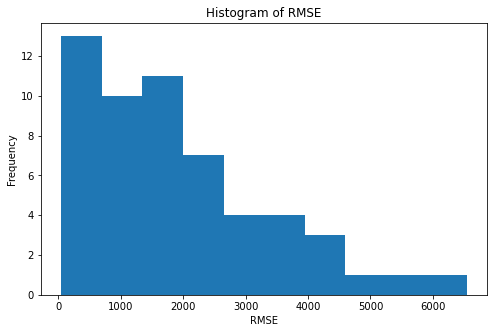

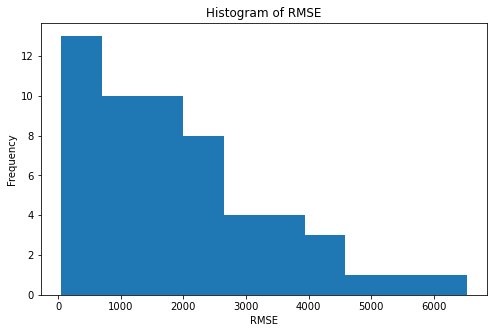

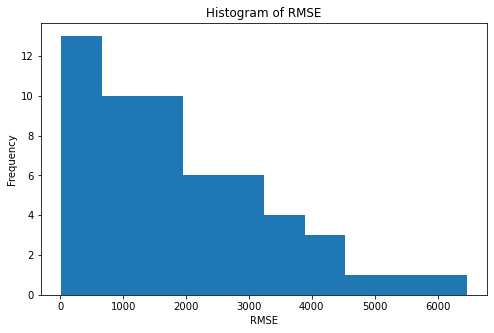

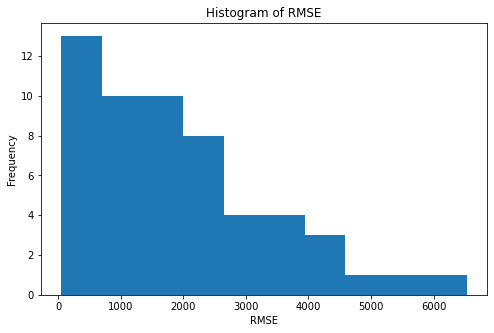

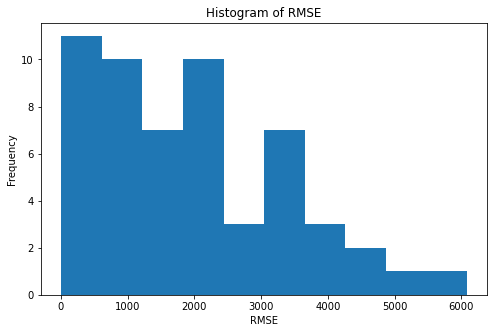

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75


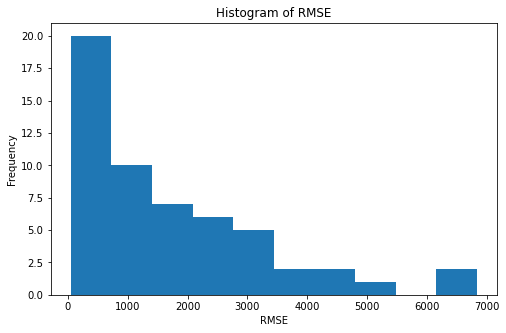

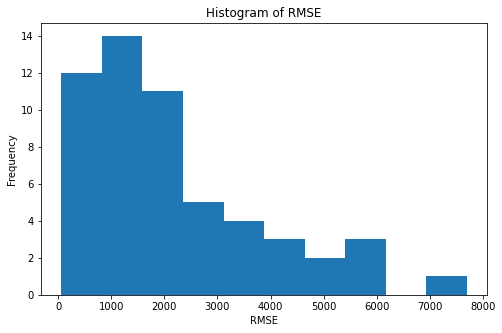

[16:16:25] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


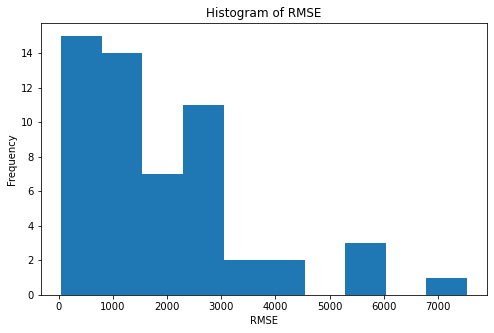

In [64]:
####Initialize K fold Cross validation
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 42)

#####Grid Space for Lasso, Ridge, ElasticNet
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

####Model Building

model_names = ['OLS', 'Lasso', 'Ridge', 'ElasticNet', 'SVR', 'Lightgbm', 'GBR', 'XGBoost']
models = [linear_model.LinearRegression(), \
            LassoCV(max_iter = int(1e7), alphas = alphas2, random_state = 42, cv = kfolds), \
                  RidgeCV(alphas = alphas_alt, cv = kfolds), \
                  ElasticNetCV(max_iter = int(1e7), alphas = e_alphas, cv = kfolds, l1_ratio = e_l1ratio), \
                  SVR(C = 20, epsilon = 0.008, gamma = 0.0003), \
                  LGBMRegressor(objective='regression', num_leaves = 4, learning_rate = 0.01, n_estimators = 5000, max_bin = 200, bagging_fraction = 0.75, \
                                bagging_freq = 5, bagging_seed = 7, feature_fraction = 0.2, feature_fraction_seed = 7, verbose = -1), \
                  GradientBoostingRegressor(n_estimators = 5000, learning_rate = 0.05, max_depth = 4, max_features = 'sqrt', min_samples_leaf = 15, \
                                            min_samples_split = 10, loss = 'huber', random_state = 42), \
                  XGBRegressor(learning_rate = 0.005, n_estimators = 10000, max_depth = 3, min_child_weight = 0, gamma = 0, subsample = 0.7, \
                               colsample_bytree = 0.7, objective = 'reg:linear', nthread = -1, scale_pos_weight = 1, seed = 27, reg_alpha = 0.00006)
         ]

fitted_models = []
Test_MAE_models = []
Test_RMSE_models = []
Test_R2_models = []
Test_mape_models = []

for model in models:
    fitted_models.append(model.fit(X_train_Yield_kg_per_ha, y_train_Yield_kg_per_ha))
    inv_transform_y_actuals = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(y_test_Yield_kg_per_ha).reshape(-1, 1))
    inv_transformed_preds = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(fitted_models[models.index(model)].predict(X_test_Yield_kg_per_ha).reshape(-1,1)))                                             
    Test_MAE_models.append(mae(inv_transform_y_actuals, inv_transformed_preds))
    Test_RMSE_models.append(rmse(inv_transform_y_actuals, inv_transformed_preds))
    Test_R2_models.append(r2(inv_transform_y_actuals, inv_transformed_preds))
    Test_mape_models.append(mape(inv_transform_y_actuals, inv_transformed_preds))
    plt.figure(figsize = (8,5))
    plt.hist(np.sqrt((inv_transform_y_actuals - inv_transformed_preds)**2))
    plt.xlabel('RMSE')
    plt.ylabel('Frequency')
    plt.title('Histogram of RMSE')
    plt.show()

OLS
MAE on test data: 1949.4920693223542
RMSE on test data: 2437.4122888868683
R squared on test data: -0.015172209705326845
MAPE on test data: 41.70070659683063


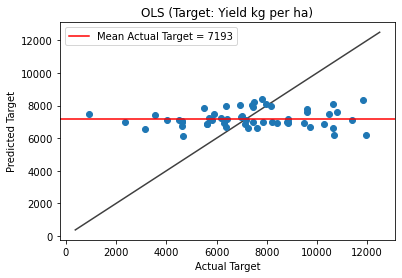

Lasso
MAE on test data: 1947.8198097003165
RMSE on test data: 2435.7104317847993
R squared on test data: -0.013755071627709281
MAPE on test data: 41.656493863747144


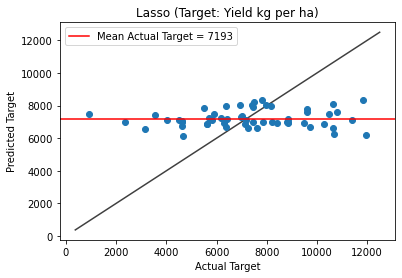

Ridge
MAE on test data: 1926.6232286750287
RMSE on test data: 2412.894961490962
R squared on test data: 0.005147809060072284
MAPE on test data: 41.291603463181985


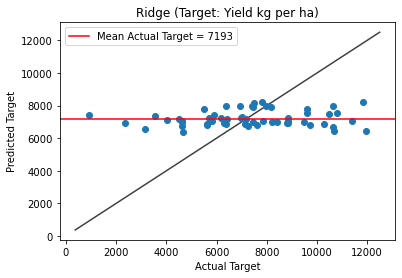

ElasticNet
MAE on test data: 1948.0290714793844
RMSE on test data: 2435.9211985546026
R squared on test data: -0.013930523621914048
MAPE on test data: 41.66200616926652


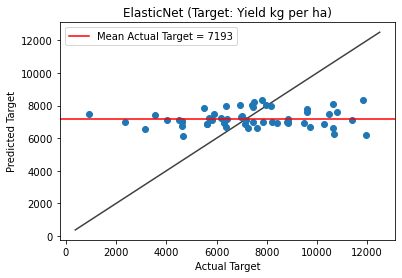

SVR
MAE on test data: 1925.8382132425727
RMSE on test data: 2392.6555471416495
R squared on test data: 0.021767495103287904
MAPE on test data: 40.441607827581585


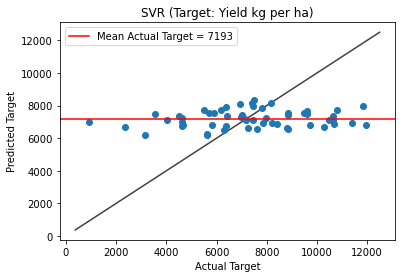

Lightgbm
MAE on test data: 1724.6642909711256
RMSE on test data: 2353.0489322589174
R squared on test data: 0.053885617132172214
MAPE on test data: 40.903703593452704


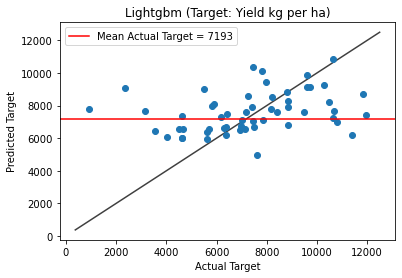

GBR
MAE on test data: 2142.881644962135
RMSE on test data: 2704.5826562922894
R squared on test data: -0.2499200798840031
MAPE on test data: 45.63311230635739


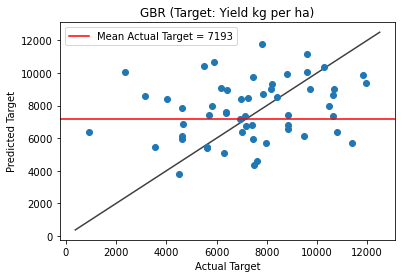

XGBoost
MAE on test data: 1935.3824796118731
RMSE on test data: 2500.208207064296
R squared on test data: -0.06815451486019852
MAPE on test data: 42.7709609360446


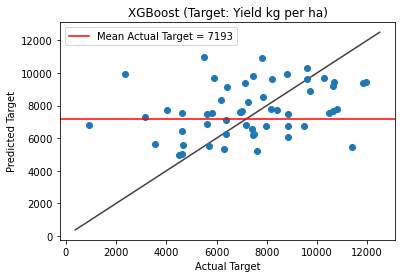

In [65]:
for model_name in model_names:
    print(model_name)
    print('MAE on test data: ' + str(Test_MAE_models[model_names.index(model_name)]))
    print('RMSE on test data: ' + str(Test_RMSE_models[model_names.index(model_name)]))
    print('R squared on test data: ' + str(Test_R2_models[model_names.index(model_name)]))
    print('MAPE on test data: ' + str(Test_mape_models[model_names.index(model_name)]))
    inv_transformed_y_actuals = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(y_test_Yield_kg_per_ha).reshape(-1, 1))
    inv_transformed_preds = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(fitted_models[model_names.index(model_name)].predict(X_test_Yield_kg_per_ha).reshape(-1,1)))
    fig, ax = plt.subplots()
    ax.axhline(y=mean_Yield_kg_per_ha, color='r', linestyle='-', label = 'Mean Actual Target = ' + str(int(mean_Yield_kg_per_ha)))
    ax.scatter(inv_transformed_y_actuals, inv_transformed_preds)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('Actual Target')
    plt.ylabel('Predicted Target')
    plt.title(model_name + ' (Target: Yield kg per ha)')
    plt.legend()
    plt.show()

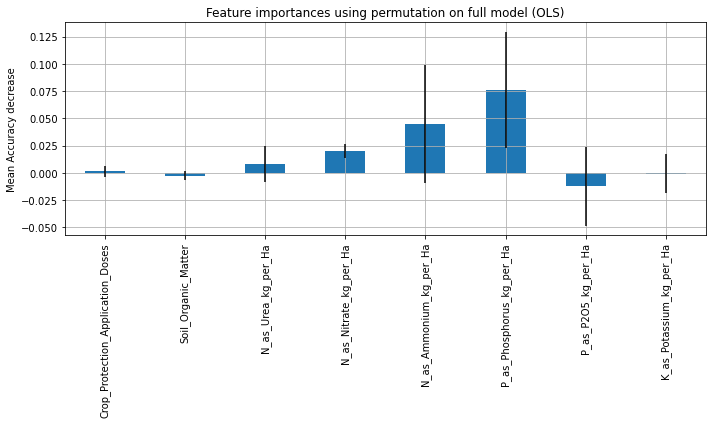

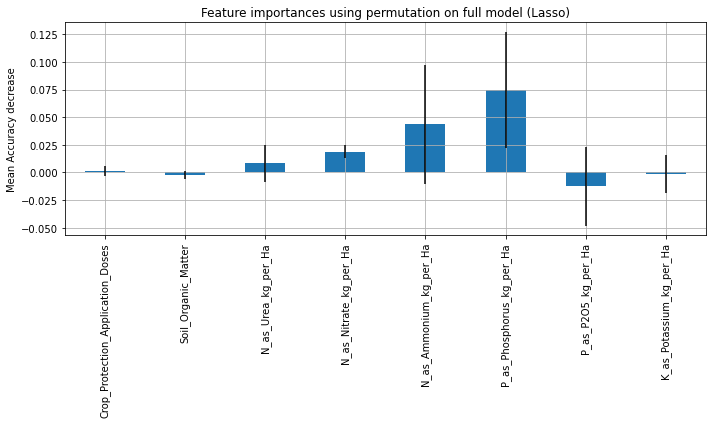

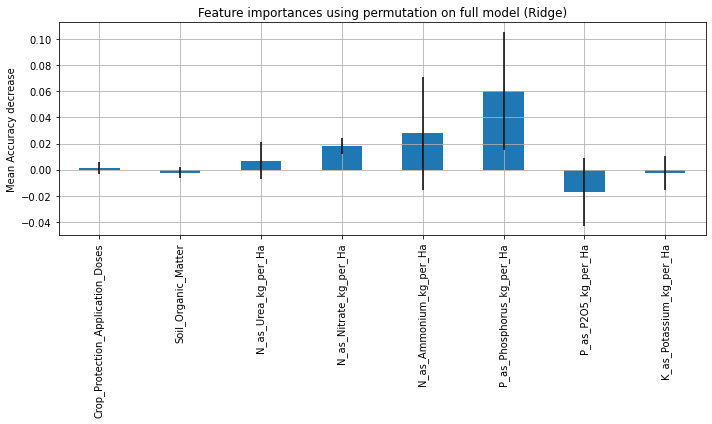

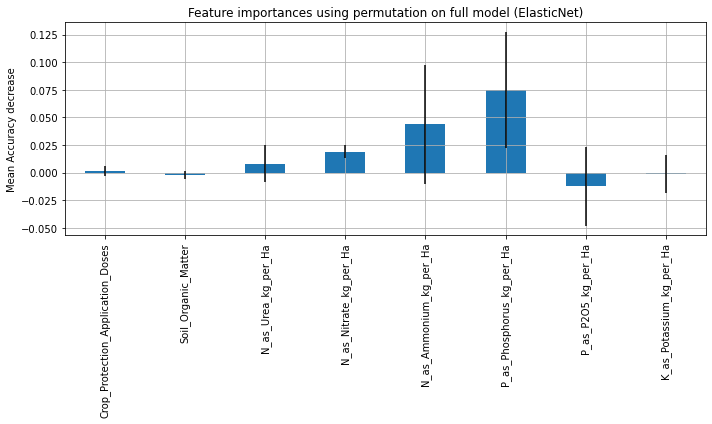

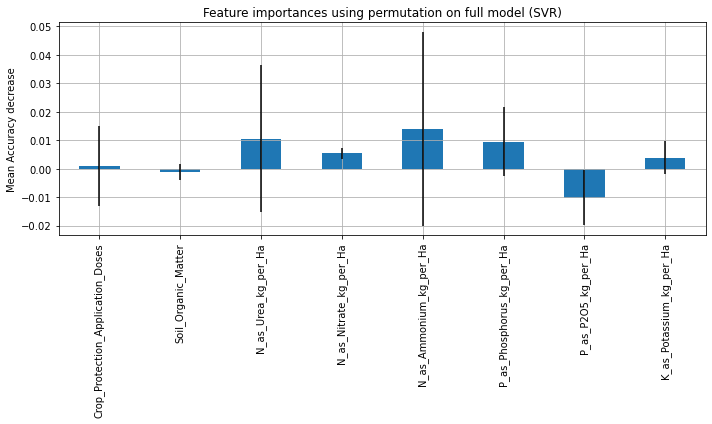

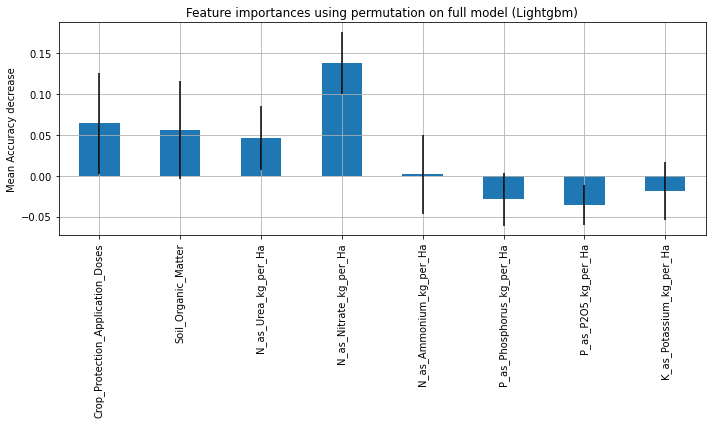

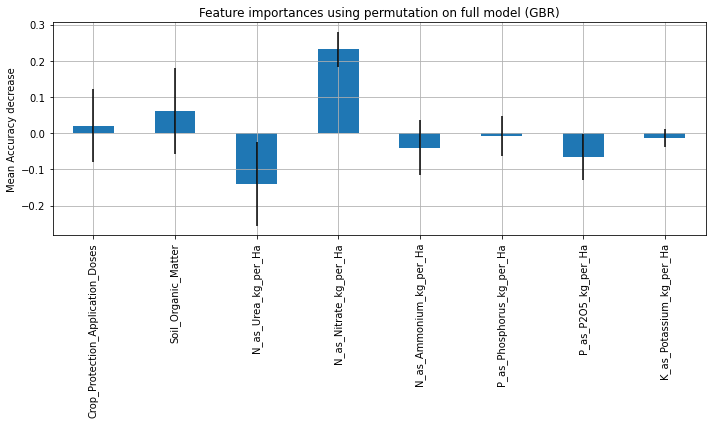

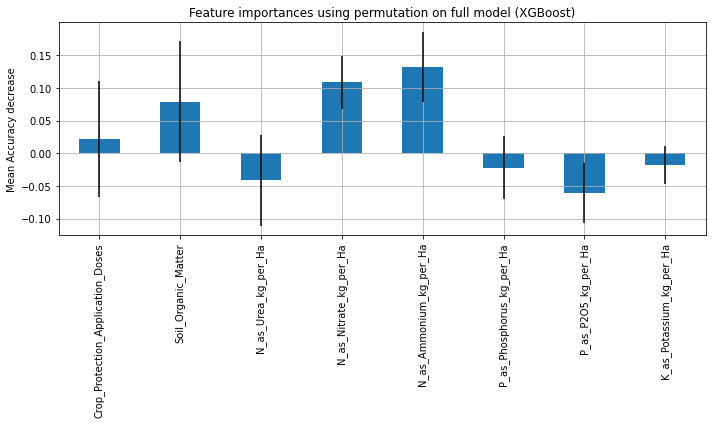

In [66]:
from sklearn.inspection import permutation_importance

for i in range(len(fitted_models)):
    feature_names = train_Yield_kg_per_ha.drop(columns = ['Yield_kg_per_Ha']).columns

    result = permutation_importance(
        fitted_models[i], X_test_Yield_kg_per_ha, y_test_Yield_kg_per_ha, n_repeats=10, random_state=42, n_jobs=2
    )

    model_importances = pd.Series(result.importances_mean, index = feature_names)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    model_importances.plot.bar(yerr = result.importances_std, ax = ax)
    ax.set_title("Feature importances using permutation on full model (" + str(model_names[i]) + ')')
    ax.set_ylabel("Mean Accuracy decrease")
    plt.grid()
    fig.tight_layout()
    plt.show()

In [69]:
#######################################
### Yield Pred Summer SOM cluster 1 ###
#######################################

df_summer = df[df['Season'] == 'SUMMER'].reset_index(drop = True)

#Yeo-Johnson Scaling
df_summer = df_summer[['Crop_Protection_Application_Doses', 'Yield_kg_per_Ha', 'Soil_Organic_Matter', \
                       'N_as_Urea_kg_per_Ha', 'N_as_Nitrate_kg_per_Ha', 'N_as_Ammonium_kg_per_Ha', 'P_as_Phosphorus_kg_per_Ha', 'P_as_P2O5_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'K_as_K2O_kg_per_Ha']]

kmeans = KMeans(n_clusters = 2)
kmeans.fit(df_summer['Soil_Organic_Matter'].values.reshape(-1,1))
df_summer['cluster'] = kmeans.labels_

df_summer_SOM_cluster_1 = df_summer[df_summer['cluster'] == 1].reset_index(drop = True)
df_summer_SOM_cluster_1 = df_summer_SOM_cluster_1.drop(columns = ['cluster'])

#train/test split
train_Yield_kg_per_ha, test_Yield_kg_per_ha = train_test_split(df_summer_SOM_cluster_1, test_size = 0.2, random_state = 60)

#x values
X_train_Yield_kg_per_ha = train_Yield_kg_per_ha.drop(columns = ['Yield_kg_per_Ha'])
X_test_Yield_kg_per_ha = test_Yield_kg_per_ha.drop(columns = ['Yield_kg_per_Ha'])

standard_scaler_X = StandardScaler().fit(X_train_Yield_kg_per_ha)
X_train_Yield_kg_per_ha = standard_scaler_X.transform(X_train_Yield_kg_per_ha)

power_transform_X = PowerTransformer(standardize = True).fit(X_train_Yield_kg_per_ha)
X_train_Yield_kg_per_ha = power_transform_X.transform(X_train_Yield_kg_per_ha)

X_test_Yield_kg_per_ha = standard_scaler_X.transform(X_test_Yield_kg_per_ha)
X_test_Yield_kg_per_ha = power_transform_X.transform(X_test_Yield_kg_per_ha)

#y_values
y_train_Yield_kg_per_ha = np.array(train_Yield_kg_per_ha['Yield_kg_per_Ha']).reshape(-1, 1)

mean_Yield_kg_per_ha = y_train_Yield_kg_per_ha.mean()

y_test_Yield_kg_per_ha = np.array(test_Yield_kg_per_ha['Yield_kg_per_Ha']).reshape(-1, 1)

standard_scaler_y = StandardScaler().fit(np.array(y_train_Yield_kg_per_ha))

y_train_Yield_kg_per_ha = standard_scaler_y.transform(y_train_Yield_kg_per_ha)

power_transform_y = PowerTransformer(standardize = False).fit(y_train_Yield_kg_per_ha)

y_train_Yield_kg_per_ha = power_transform_y.transform(y_train_Yield_kg_per_ha)

y_test_Yield_kg_per_ha = standard_scaler_y.transform(y_test_Yield_kg_per_ha)

y_test_Yield_kg_per_ha = power_transform_y.transform(y_test_Yield_kg_per_ha)

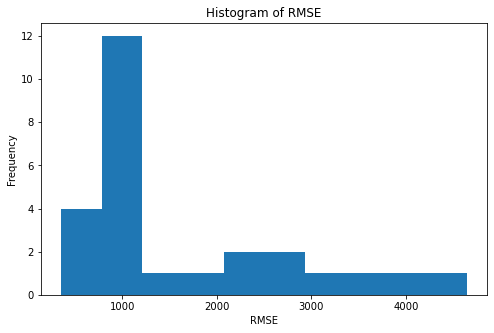

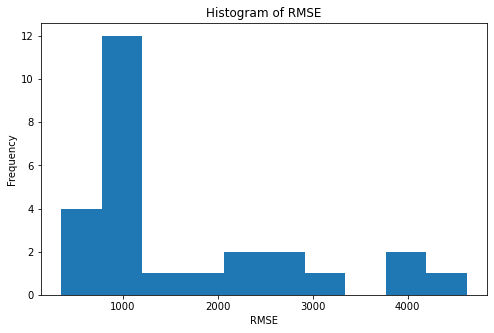

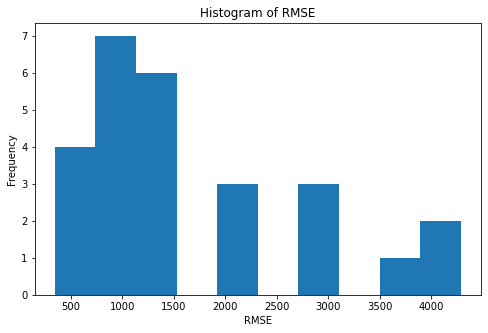

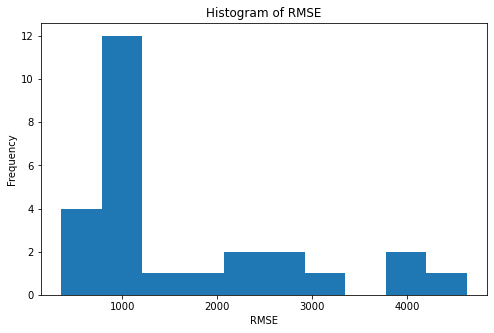

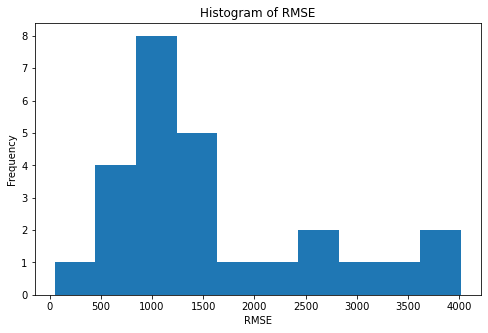

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75


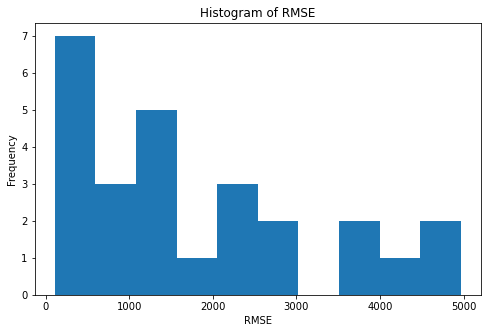

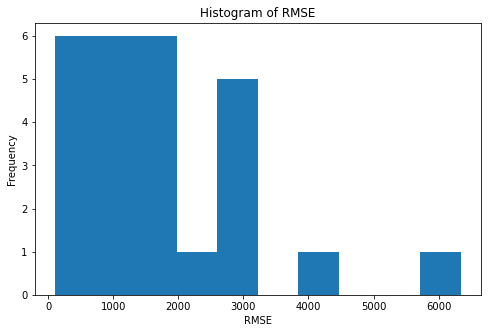

[16:33:02] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


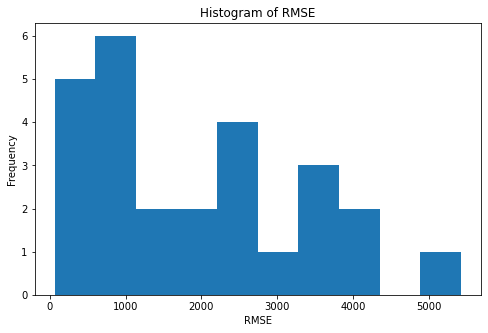

In [70]:
####Initialize K fold Cross validation
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 42)

#####Grid Space for Lasso, Ridge, ElasticNet
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

####Model Building

model_names = ['OLS', 'Lasso', 'Ridge', 'ElasticNet', 'SVR', 'Lightgbm', 'GBR', 'XGBoost']
models = [linear_model.LinearRegression(), \
            LassoCV(max_iter = int(1e7), alphas = alphas2, random_state = 42, cv = kfolds), \
                  RidgeCV(alphas = alphas_alt, cv = kfolds), \
                  ElasticNetCV(max_iter = int(1e7), alphas = e_alphas, cv = kfolds, l1_ratio = e_l1ratio), \
                  SVR(C = 20, epsilon = 0.008, gamma = 0.0003), \
                  LGBMRegressor(objective='regression', num_leaves = 4, learning_rate = 0.01, n_estimators = 5000, max_bin = 200, bagging_fraction = 0.75, \
                                bagging_freq = 5, bagging_seed = 7, feature_fraction = 0.2, feature_fraction_seed = 7, verbose = -1), \
                  GradientBoostingRegressor(n_estimators = 5000, learning_rate = 0.05, max_depth = 4, max_features = 'sqrt', min_samples_leaf = 15, \
                                            min_samples_split = 10, loss = 'huber', random_state = 42), \
                  XGBRegressor(learning_rate = 0.005, n_estimators = 10000, max_depth = 3, min_child_weight = 0, gamma = 0, subsample = 0.7, \
                               colsample_bytree = 0.7, objective = 'reg:linear', nthread = -1, scale_pos_weight = 1, seed = 27, reg_alpha = 0.00006)
         ]

fitted_models = []
Test_MAE_models = []
Test_RMSE_models = []
Test_R2_models = []
Test_mape_models = []

for model in models:
    fitted_models.append(model.fit(X_train_Yield_kg_per_ha, y_train_Yield_kg_per_ha))
    inv_transform_y_actuals = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(y_test_Yield_kg_per_ha).reshape(-1, 1))
    inv_transformed_preds = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(fitted_models[models.index(model)].predict(X_test_Yield_kg_per_ha).reshape(-1,1)))                                             
    Test_MAE_models.append(mae(inv_transform_y_actuals, inv_transformed_preds))
    Test_RMSE_models.append(rmse(inv_transform_y_actuals, inv_transformed_preds))
    Test_R2_models.append(r2(inv_transform_y_actuals, inv_transformed_preds))
    Test_mape_models.append(mape(inv_transform_y_actuals, inv_transformed_preds))
    plt.figure(figsize = (8,5))
    plt.hist(np.sqrt((inv_transform_y_actuals - inv_transformed_preds)**2))
    plt.xlabel('RMSE')
    plt.ylabel('Frequency')
    plt.title('Histogram of RMSE')
    plt.show()

OLS
MAE on test data: 1632.185689493988
RMSE on test data: 2010.1869108326562
R squared on test data: -0.07887847885746413
MAPE on test data: 22.146576298334196


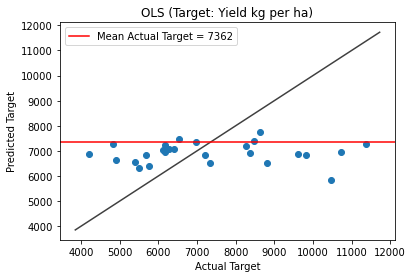

Lasso
MAE on test data: 1633.5505633357966
RMSE on test data: 2009.1513705904724
R squared on test data: -0.07776720476759436
MAPE on test data: 22.17414008193215


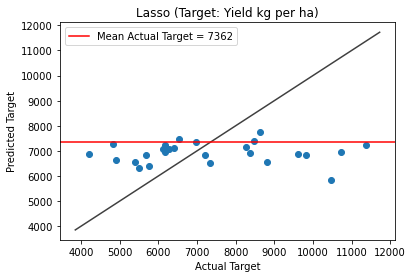

Ridge
MAE on test data: 1671.28894984706
RMSE on test data: 2015.2288531531253
R squared on test data: -0.08429734302051428
MAPE on test data: 22.850165405028065


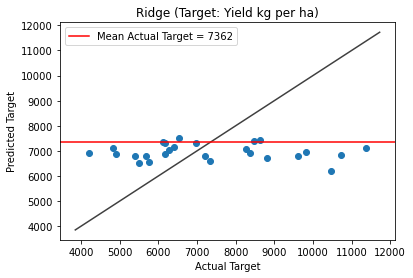

ElasticNet
MAE on test data: 1633.3847220761659
RMSE on test data: 2009.284944917822
R squared on test data: -0.07791051583617237
MAPE on test data: 22.17077096827055


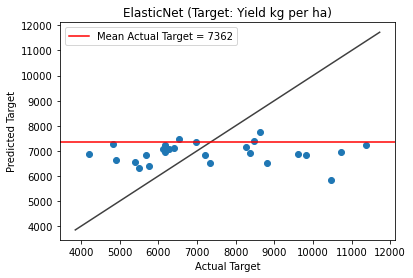

SVR
MAE on test data: 1598.8774757130507
RMSE on test data: 1904.5622929493486
R squared on test data: 0.031521437333679625
MAPE on test data: 22.164613050763098


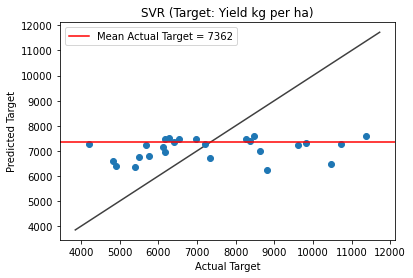

Lightgbm
MAE on test data: 1802.5159337170637
RMSE on test data: 2308.043683796816
R squared on test data: -0.422288495396296
MAPE on test data: 24.944292172628753


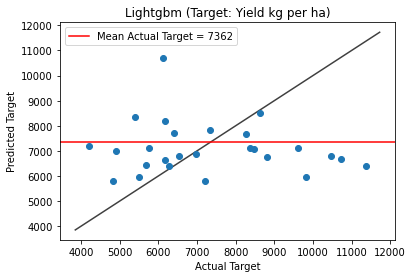

GBR
MAE on test data: 1762.177266353542
RMSE on test data: 2231.567253552632
R squared on test data: -0.32959571914991015
MAPE on test data: 23.85215051297365


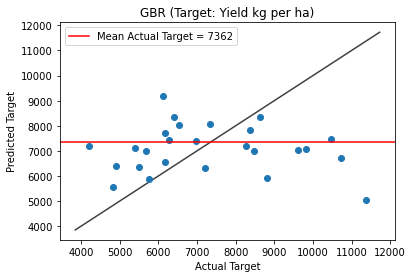

XGBoost
MAE on test data: 1926.3394334436905
RMSE on test data: 2397.1780295389935
R squared on test data: -0.5342644624954869
MAPE on test data: 27.129353099800145


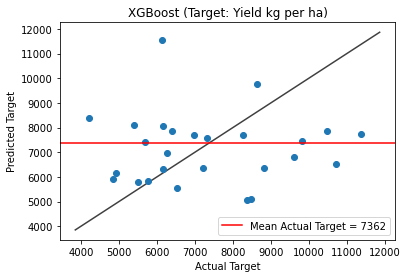

In [71]:
for model_name in model_names:
    print(model_name)
    print('MAE on test data: ' + str(Test_MAE_models[model_names.index(model_name)]))
    print('RMSE on test data: ' + str(Test_RMSE_models[model_names.index(model_name)]))
    print('R squared on test data: ' + str(Test_R2_models[model_names.index(model_name)]))
    print('MAPE on test data: ' + str(Test_mape_models[model_names.index(model_name)]))
    inv_transformed_y_actuals = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(y_test_Yield_kg_per_ha).reshape(-1, 1))
    inv_transformed_preds = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(fitted_models[model_names.index(model_name)].predict(X_test_Yield_kg_per_ha).reshape(-1,1)))
    fig, ax = plt.subplots()
    ax.axhline(y=mean_Yield_kg_per_ha, color='r', linestyle='-', label = 'Mean Actual Target = ' + str(int(mean_Yield_kg_per_ha)))
    ax.scatter(inv_transformed_y_actuals, inv_transformed_preds)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('Actual Target')
    plt.ylabel('Predicted Target')
    plt.title(model_name + ' (Target: Yield kg per ha)')
    plt.legend()
    plt.show()

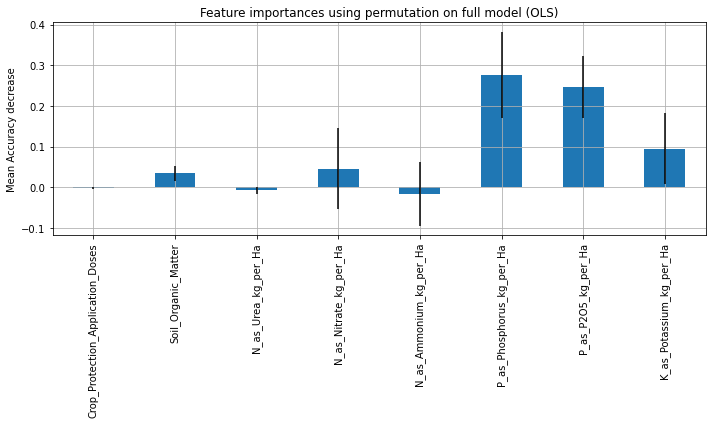

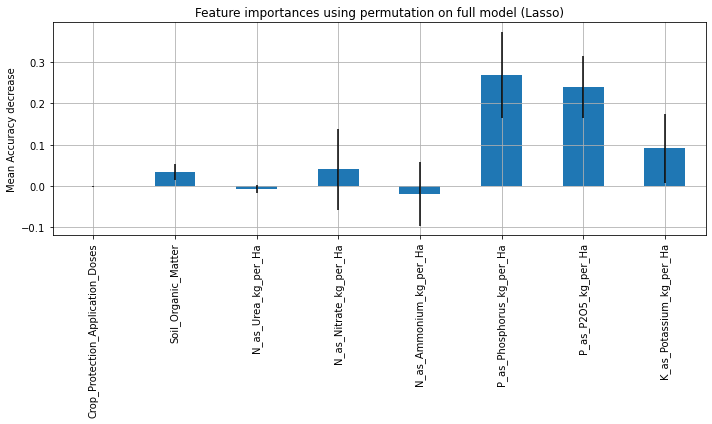

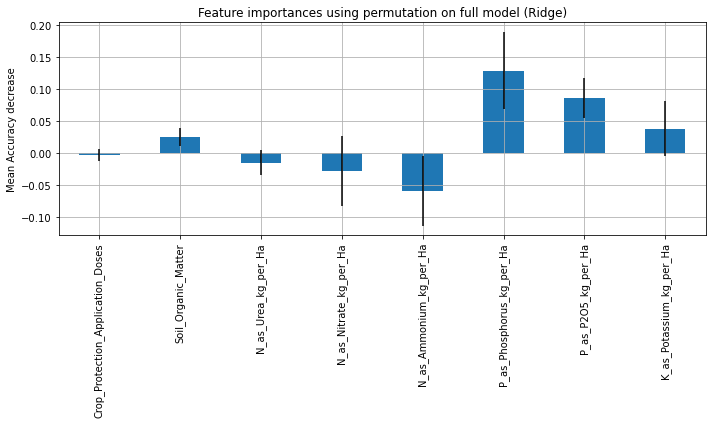

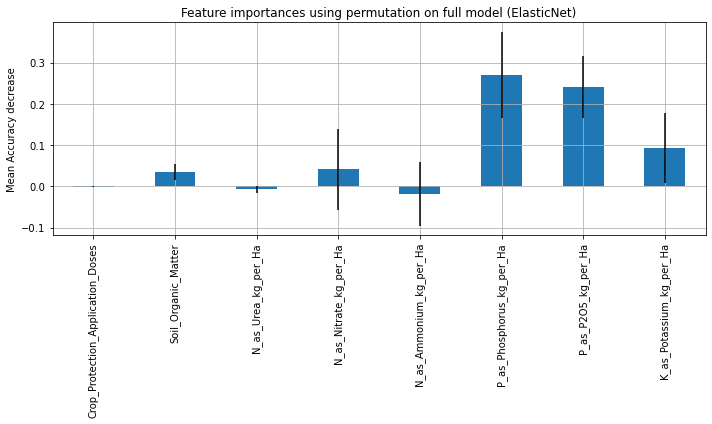

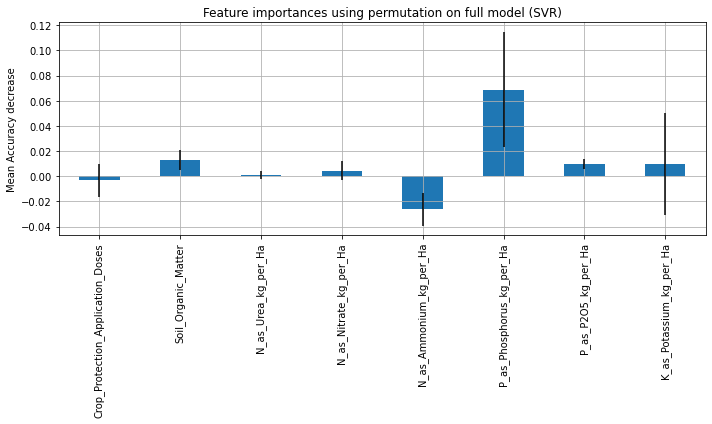

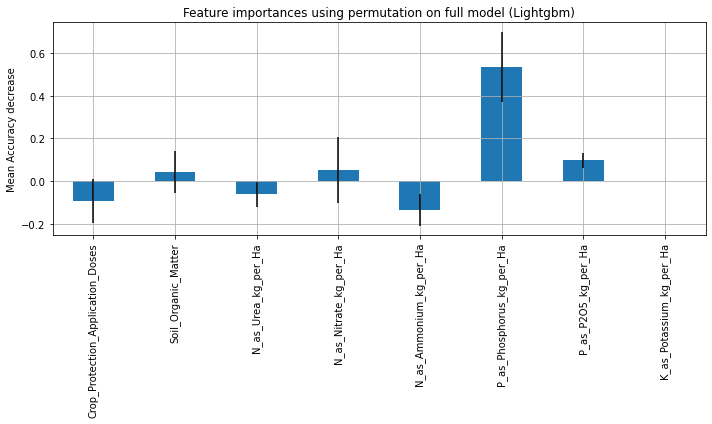

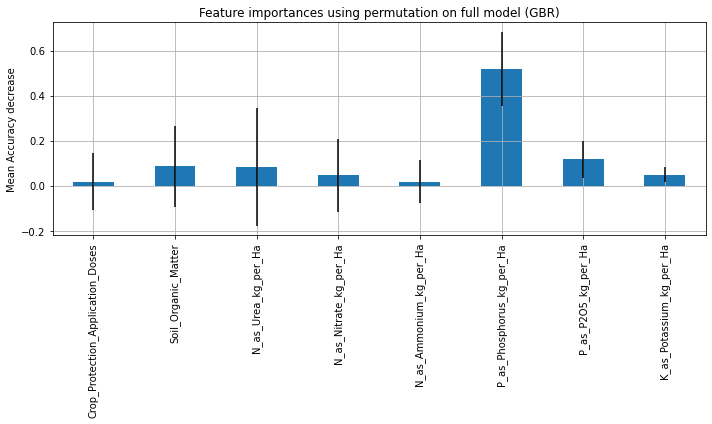

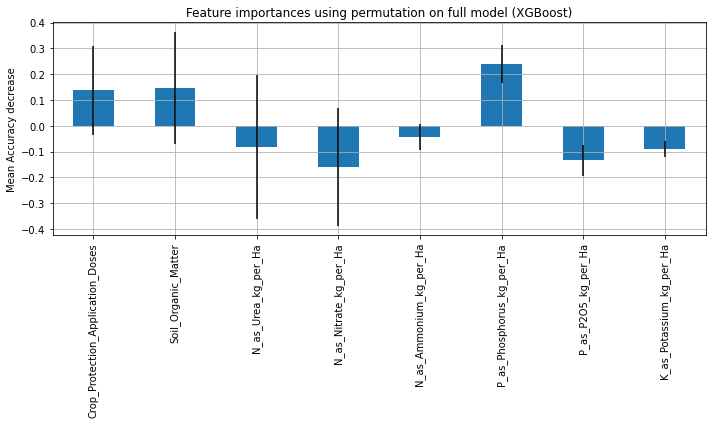

In [72]:
from sklearn.inspection import permutation_importance

for i in range(len(fitted_models)):
    feature_names = train_Yield_kg_per_ha.drop(columns = ['Yield_kg_per_Ha']).columns

    result = permutation_importance(
        fitted_models[i], X_test_Yield_kg_per_ha, y_test_Yield_kg_per_ha, n_repeats=10, random_state=42, n_jobs=2
    )

    model_importances = pd.Series(result.importances_mean, index = feature_names)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    model_importances.plot.bar(yerr = result.importances_std, ax = ax)
    ax.set_title("Feature importances using permutation on full model (" + str(model_names[i]) + ')')
    ax.set_ylabel("Mean Accuracy decrease")
    plt.grid()
    fig.tight_layout()
    plt.show()

In [78]:
#######################################
### Yield Pred Winter SOM cluster 0 ###
#######################################

df_winter = df[df['Season'] == 'WINTER'].reset_index(drop = True)

#Yeo-Johnson Scaling
df_winter = df_winter[['Crop_Protection_Application_Doses', 'Yield_kg_per_Ha', 'Soil_Organic_Matter', \
                       'N_as_Urea_kg_per_Ha', 'N_as_Nitrate_kg_per_Ha', 'N_as_Ammonium_kg_per_Ha', 'P_as_Phosphorus_kg_per_Ha', 'P_as_P2O5_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'K_as_K2O_kg_per_Ha']]

kmeans = KMeans(n_clusters = 2)
kmeans.fit(df_winter['Soil_Organic_Matter'].values.reshape(-1,1))
df_winter['cluster'] = kmeans.labels_

df_winter_SOM_cluster_0 = df_winter[df_winter['cluster'] == 0].reset_index(drop = True)
df_winter_SOM_cluster_0 = df_winter_SOM_cluster_0.drop(columns = ['cluster'])

df_winter_SOM_cluster_0 = df_winter_SOM_cluster_0[(df_winter_SOM_cluster_0['Yield_kg_per_Ha'] > df_winter_SOM_cluster_0['Yield_kg_per_Ha'].quantile(.1)) \
                                                               & (df_winter_SOM_cluster_0['Yield_kg_per_Ha'] < df_winter_SOM_cluster_0['Yield_kg_per_Ha'].quantile(.9))].reset_index(drop = True)
print(display(df_winter_SOM_cluster_0))
df_winter_SOM_cluster_1 = df_winter[df_winter['cluster'] == 1].reset_index(drop = True)
df_winter_SOM_cluster_1 = df_winter_SOM_cluster_1.drop(columns = ['cluster'])

# df_winter_SOM_cluster_1 = df_winter_SOM_cluster_1[(df_summer_SOM_cluster_1['Yield_kg_per_Ha'] > df_winter_SOM_cluster_1['Yield_kg_per_Ha'].quantile(.05)) \
#                                                                & (df_winter_SOM_cluster_1['Yield_kg_per_Ha'] < df_winter_SOM_cluster_1['Yield_kg_per_Ha'].quantile(.95))].reset_index(drop = True)
#train/test split
train_Yield_kg_per_ha, test_Yield_kg_per_ha = train_test_split(df_winter_SOM_cluster_0, test_size = 0.2, random_state = 50)
#60,27
#.2/.8
#x values
X_train_Yield_kg_per_ha = train_Yield_kg_per_ha.drop(columns = ['Yield_kg_per_Ha'])
X_test_Yield_kg_per_ha = test_Yield_kg_per_ha.drop(columns = ['Yield_kg_per_Ha'])

standard_scaler_X = StandardScaler().fit(X_train_Yield_kg_per_ha)
X_train_Yield_kg_per_ha = standard_scaler_X.transform(X_train_Yield_kg_per_ha)

power_transform_X = PowerTransformer(standardize = True).fit(X_train_Yield_kg_per_ha)
X_train_Yield_kg_per_ha = power_transform_X.transform(X_train_Yield_kg_per_ha)

X_test_Yield_kg_per_ha = standard_scaler_X.transform(X_test_Yield_kg_per_ha)
X_test_Yield_kg_per_ha = power_transform_X.transform(X_test_Yield_kg_per_ha)

#y_values
y_train_Yield_kg_per_ha = np.array(train_Yield_kg_per_ha['Yield_kg_per_Ha']).reshape(-1, 1)

mean_Yield_kg_per_ha = y_train_Yield_kg_per_ha.mean()

y_test_Yield_kg_per_ha = np.array(test_Yield_kg_per_ha['Yield_kg_per_Ha']).reshape(-1, 1)

standard_scaler_y = StandardScaler().fit(np.array(y_train_Yield_kg_per_ha))

y_train_Yield_kg_per_ha = standard_scaler_y.transform(y_train_Yield_kg_per_ha)

power_transform_y = PowerTransformer(standardize = False).fit(y_train_Yield_kg_per_ha)

y_train_Yield_kg_per_ha = power_transform_y.transform(y_train_Yield_kg_per_ha)

y_test_Yield_kg_per_ha = standard_scaler_y.transform(y_test_Yield_kg_per_ha)

y_test_Yield_kg_per_ha = power_transform_y.transform(y_test_Yield_kg_per_ha)

,Crop_Protection_Application_Doses,Yield_kg_per_Ha,Soil_Organic_Matter,N_as_Urea_kg_per_Ha,N_as_Nitrate_kg_per_Ha,N_as_Ammonium_kg_per_Ha,P_as_Phosphorus_kg_per_Ha,P_as_P2O5_kg_per_Ha,K_as_Potassium_kg_per_Ha,K_as_K2O_kg_per_Ha
0,9.0,7678.888889,2.500000,151.80,18.00,32.60,90.0,5.2,96.0,0.0
1,9.0,7756.363636,2.500000,128.80,18.00,32.60,90.0,5.2,90.0,0.0
2,10.0,8235.200000,2.500000,128.80,18.00,32.60,90.0,5.2,102.0,0.0
3,9.0,8178.000000,2.500000,151.80,24.00,32.05,120.0,2.6,0.0,138.0
4,10.0,7470.315789,2.500000,128.80,18.00,33.15,90.0,7.8,0.0,102.0
...,...,...,...,...,...,...,...,...,...,...
293,15.0,5392.731742,2.800000,0.00,0.00,44.10,0.0,0.0,0.0,120.0
294,22.0,5610.540541,2.893750,126.50,0.00,83.90,0.0,98.8,0.0,90.0
295,19.0,5610.597015,2.812903,39.76,24.92,108.82,0.0,98.8,0.0,90.0
296,21.0,6707.400000,2.500000,115.00,150.00,0.00,0.0,0.0,100.0,0.0


None


0.010950652187252219


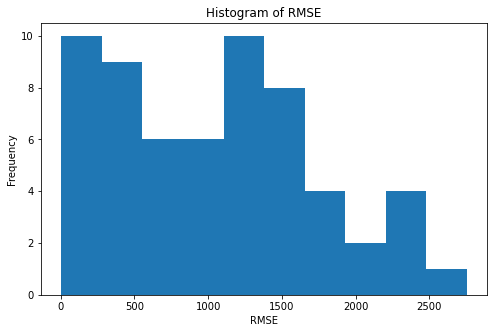

0.01050083091881815


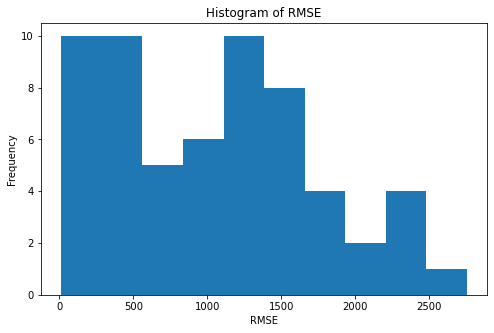

0.010664286069635875


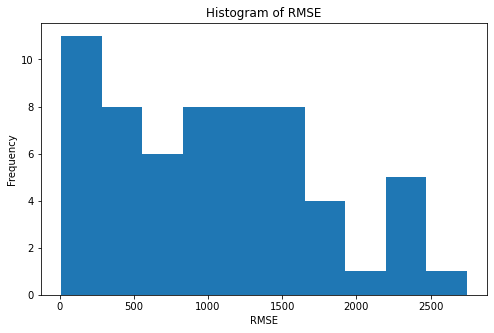

0.0105587773757152


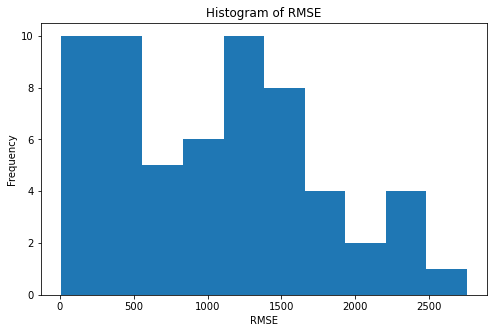

-0.004972237989925965


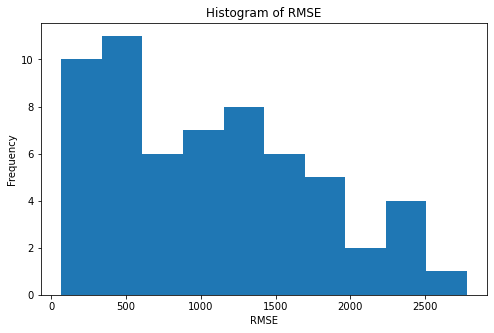

0.04769021055211309


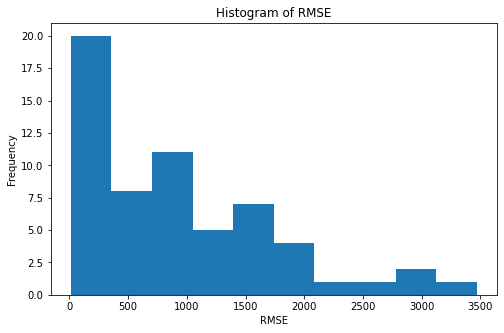

[15:48:13] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
0.10661737158832696


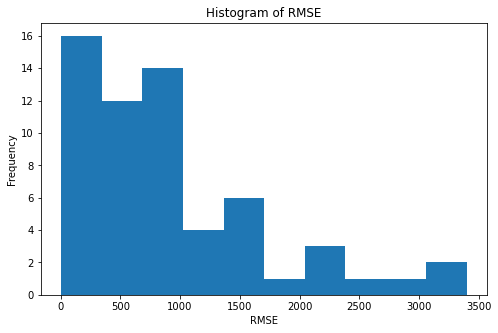

In [79]:
from sklearn.metrics import r2_score

####Initialize K fold Cross validation
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 42)

#####Grid Space for Lasso, Ridge, ElasticNet
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

####Model Building

model_names = ['OLS', 'Lasso', 'Ridge', 'ElasticNet', 'SVR', 'GBR', 'XGBoost']
models = [linear_model.LinearRegression(), \
            LassoCV(max_iter = int(1e7), alphas = alphas2, random_state = 42, cv = kfolds), \
                  RidgeCV(alphas = alphas_alt, cv = kfolds), \
                  ElasticNetCV(max_iter = int(1e7), alphas = e_alphas, cv = kfolds, l1_ratio = e_l1ratio), \
                  SVR(C = 20, epsilon = 0.008, gamma = 0.0003), \
#                   LGBMRegressor(objective='regression', num_leaves = 4, learning_rate = 0.01, n_estimators = 5000, max_bin = 200, bagging_fraction = 0.75, \
#                                 bagging_freq = 5, bagging_seed = 7, feature_fraction = 0.2, feature_fraction_seed = 7, verbose = -1), \
                  GradientBoostingRegressor(n_estimators = 5000, learning_rate = 0.05, max_depth = 4, max_features = 'sqrt', min_samples_leaf = 15, \
                                            min_samples_split = 10, loss = 'huber', random_state = 42), \
                  XGBRegressor(learning_rate = 0.005, n_estimators = 10000, max_depth = 3, min_child_weight = 0, gamma = 0, subsample = 0.7, \
                               colsample_bytree = 0.7, objective = 'reg:linear', nthread = -1, scale_pos_weight = 1, seed = 27, reg_alpha = 0.00006)
         ]

fitted_models = []
Test_MAE_models = []
Test_RMSE_models = []
Test_R2_models = []
Test_mape_models = []

for model in models:
    fitted_models.append(model.fit(X_train_Yield_kg_per_ha, y_train_Yield_kg_per_ha))
    inv_transform_y_actuals = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(y_test_Yield_kg_per_ha).reshape(-1, 1))
    inv_transformed_preds = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(fitted_models[models.index(model)].predict(X_test_Yield_kg_per_ha).reshape(-1,1)))                                             
    Test_MAE_models.append(mae(inv_transform_y_actuals, inv_transformed_preds))
    Test_RMSE_models.append(rmse(inv_transform_y_actuals, inv_transformed_preds))
    Test_R2_models.append(r2(inv_transform_y_actuals, inv_transformed_preds))
    print(str(r2_score(inv_transform_y_actuals, inv_transformed_preds)))

    Test_mape_models.append(mape(inv_transform_y_actuals, inv_transformed_preds))
    plt.figure(figsize = (8,5))
    plt.hist(np.sqrt((inv_transform_y_actuals - inv_transformed_preds)**2))
    plt.xlabel('RMSE')
    plt.ylabel('Frequency')
    plt.title('Histogram of RMSE')
    plt.show()

OLS
MAE on test data: 1047.5911708656483
RMSE on test data: 1272.3821517591552
R squared on test data: 0.010950652187252219
MAPE on test data: 16.85561217973715


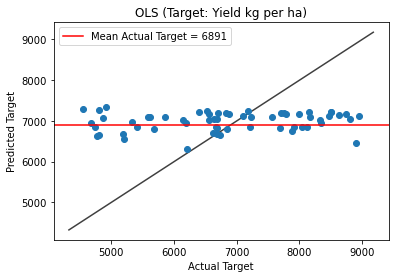

Lasso
MAE on test data: 1048.2932527968626
RMSE on test data: 1272.6714596150705
R squared on test data: 0.01050083091881815
MAPE on test data: 16.867769470579898


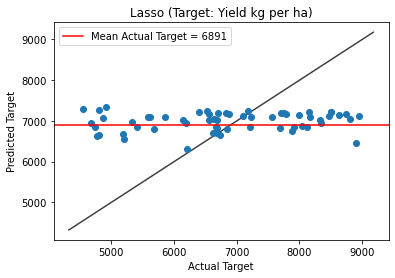

Ridge
MAE on test data: 1050.8049085387097
RMSE on test data: 1272.5663391139767
R squared on test data: 0.010664286069635875
MAPE on test data: 16.90907269345078


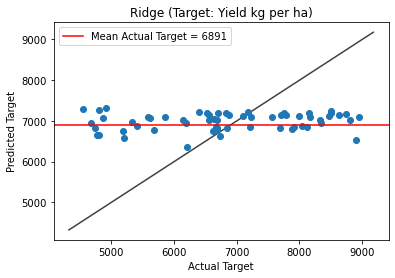

ElasticNet
MAE on test data: 1048.1885502942464
RMSE on test data: 1272.6341943581135
R squared on test data: 0.0105587773757152
MAPE on test data: 16.86599576553475


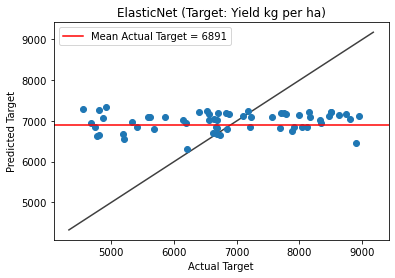

SVR
MAE on test data: 1068.1054416704462
RMSE on test data: 1282.58341662853
R squared on test data: -0.004972237989925965
MAPE on test data: 17.258068822283395


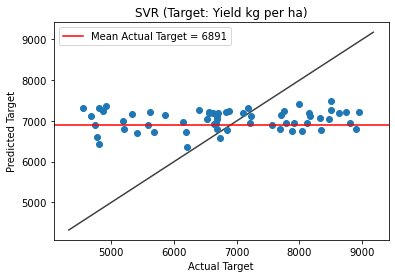

GBR
MAE on test data: 941.4222542797153
RMSE on test data: 1248.5263495903055
R squared on test data: 0.04769021055211309
MAPE on test data: 14.870753190624589


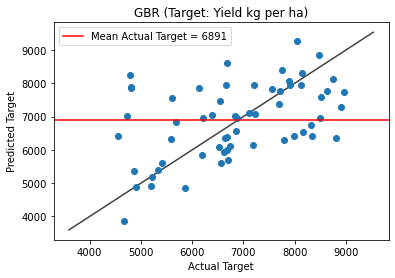

XGBoost
MAE on test data: 899.7453582220237
RMSE on test data: 1209.2813072925285
R squared on test data: 0.10661737158832696
MAPE on test data: 14.46646101936446


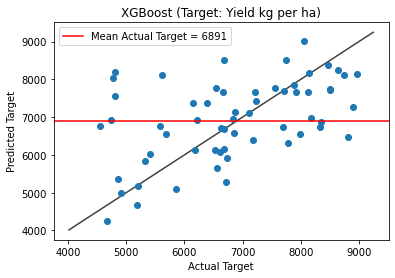

In [80]:
for model_name in model_names:
    print(model_name)
    print('MAE on test data: ' + str(Test_MAE_models[model_names.index(model_name)]))
    print('RMSE on test data: ' + str(Test_RMSE_models[model_names.index(model_name)]))
    print('R squared on test data: ' + str(Test_R2_models[model_names.index(model_name)]))
    print('MAPE on test data: ' + str(Test_mape_models[model_names.index(model_name)]))
    inv_transformed_y_actuals = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(y_test_Yield_kg_per_ha).reshape(-1, 1))
    inv_transformed_preds = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(fitted_models[model_names.index(model_name)].predict(X_test_Yield_kg_per_ha).reshape(-1,1)))
    fig, ax = plt.subplots()
    ax.axhline(y=mean_Yield_kg_per_ha, color='r', linestyle='-', label = 'Mean Actual Target = ' + str(int(mean_Yield_kg_per_ha)))
    ax.scatter(inv_transformed_y_actuals, inv_transformed_preds)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('Actual Target')
    plt.ylabel('Predicted Target')
    plt.title(model_name + ' (Target: Yield kg per ha)')
    plt.legend()
    plt.show()

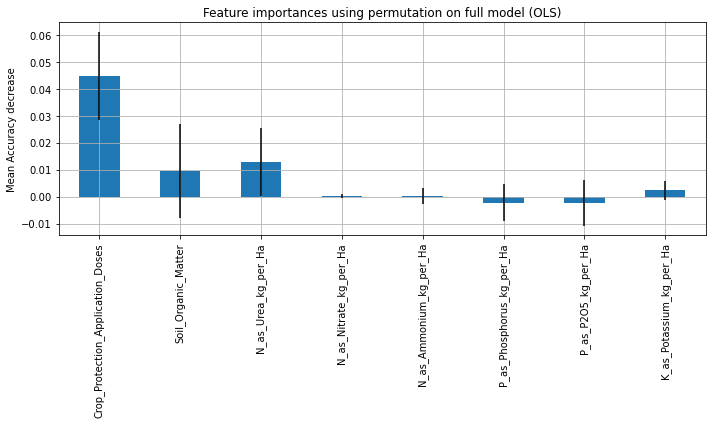

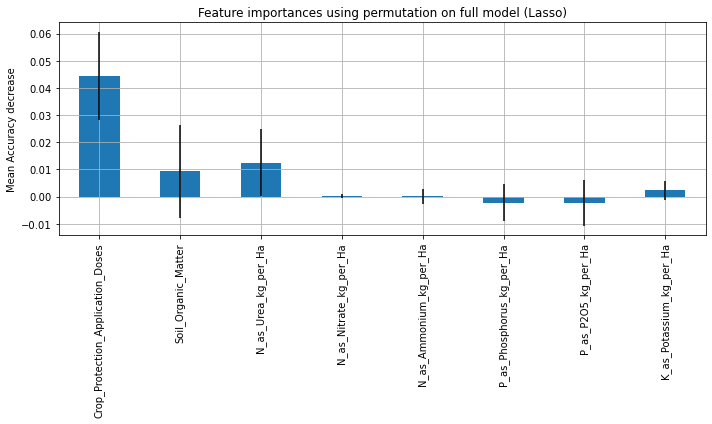

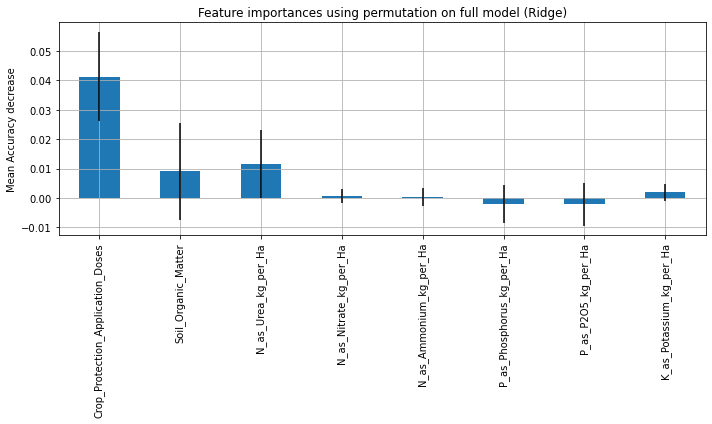

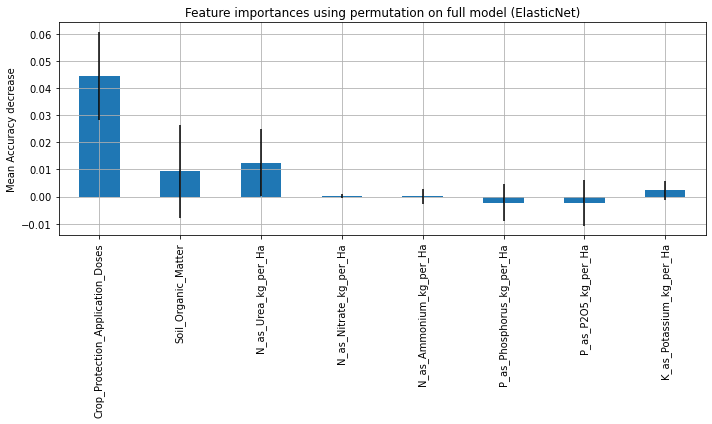

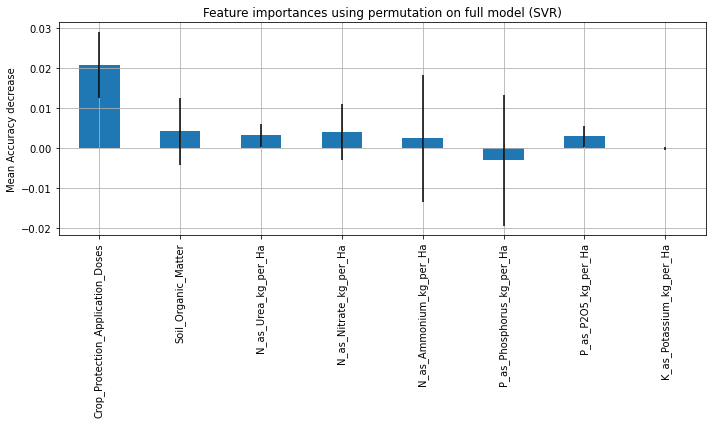

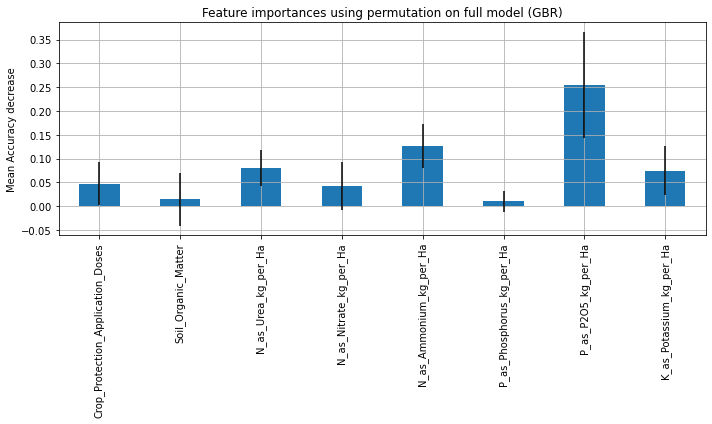

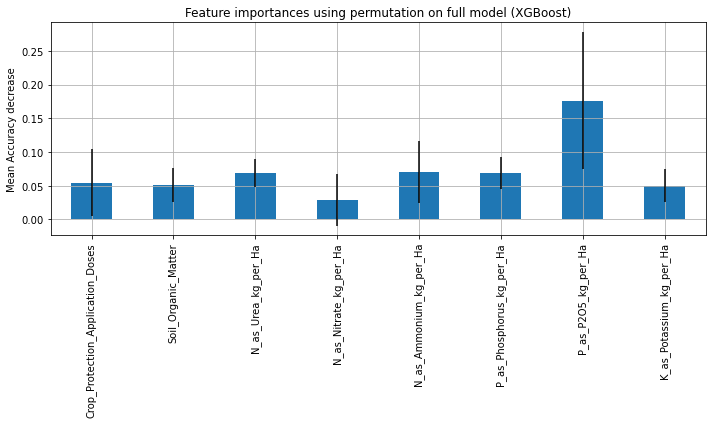

In [12]:
from sklearn.inspection import permutation_importance

for i in range(len(fitted_models)):
    feature_names = train_Yield_kg_per_ha.drop(columns = ['Yield_kg_per_Ha']).columns

    result = permutation_importance(
        fitted_models[i], X_test_Yield_kg_per_ha, y_test_Yield_kg_per_ha, n_repeats=10, random_state=42, n_jobs=2
    )

    model_importances = pd.Series(result.importances_mean, index = feature_names)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    model_importances.plot.bar(yerr = result.importances_std, ax = ax)
    ax.set_title("Feature importances using permutation on full model (" + str(model_names[i]) + ')')
    ax.set_ylabel("Mean Accuracy decrease")
    plt.grid()
    fig.tight_layout()
    plt.show()

In [37]:
#######################################
### Yield Pred Winter SOM cluster 1 ###
#######################################
#50, 28
#train/test split
train_Yield_kg_per_ha, test_Yield_kg_per_ha = train_test_split(df_winter_SOM_cluster_1, test_size = 0.2, random_state = 60)
print(display(train_Yield_kg_per_ha))

#x values
X_train_Yield_kg_per_ha = train_Yield_kg_per_ha.drop(columns = ['Yield_kg_per_Ha'])
X_test_Yield_kg_per_ha = test_Yield_kg_per_ha.drop(columns = ['Yield_kg_per_Ha'])

standard_scaler_X = StandardScaler().fit(X_train_Yield_kg_per_ha)
X_train_Yield_kg_per_ha = standard_scaler_X.transform(X_train_Yield_kg_per_ha)

power_transform_X = PowerTransformer(standardize = True).fit(X_train_Yield_kg_per_ha)
X_train_Yield_kg_per_ha = power_transform_X.transform(X_train_Yield_kg_per_ha)

X_test_Yield_kg_per_ha = standard_scaler_X.transform(X_test_Yield_kg_per_ha)
X_test_Yield_kg_per_ha = power_transform_X.transform(X_test_Yield_kg_per_ha)

#y_values
y_train_Yield_kg_per_ha = np.array(train_Yield_kg_per_ha['Yield_kg_per_Ha']).reshape(-1, 1)

mean_Yield_kg_per_ha = y_train_Yield_kg_per_ha.mean()

y_test_Yield_kg_per_ha = np.array(test_Yield_kg_per_ha['Yield_kg_per_Ha']).reshape(-1, 1)

standard_scaler_y = StandardScaler().fit(np.array(y_train_Yield_kg_per_ha))

y_train_Yield_kg_per_ha = standard_scaler_y.transform(y_train_Yield_kg_per_ha)

power_transform_y = PowerTransformer(standardize = False).fit(y_train_Yield_kg_per_ha)

y_train_Yield_kg_per_ha = power_transform_y.transform(y_train_Yield_kg_per_ha)

y_test_Yield_kg_per_ha = standard_scaler_y.transform(y_test_Yield_kg_per_ha)

y_test_Yield_kg_per_ha = power_transform_y.transform(y_test_Yield_kg_per_ha)

,Crop_Protection_Application_Doses,Yield_kg_per_Ha,Soil_Organic_Matter,N_as_Urea_kg_per_Ha,N_as_Nitrate_kg_per_Ha,N_as_Ammonium_kg_per_Ha,P_as_Phosphorus_kg_per_Ha,P_as_P2O5_kg_per_Ha,K_as_Potassium_kg_per_Ha
222,15.0,4029.247312,2.50,92.0,80.0,0.00,0.0,0.00,80.0
77,15.0,7230.178571,2.50,0.0,33.0,0.00,99.0,0.00,0.0
50,18.0,7190.566038,2.50,165.6,0.0,22.33,0.0,105.56,0.0
24,15.0,6489.500000,2.50,0.0,0.0,25.30,0.0,119.60,0.0
112,16.0,7288.921569,2.50,138.0,0.0,31.50,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...
70,18.0,8048.495575,2.50,59.8,26.0,0.00,119.6,0.00,0.0
132,15.0,8659.250000,2.50,184.0,0.0,34.65,0.0,163.80,0.0
289,15.0,2775.071429,3.01,55.2,0.0,0.00,0.0,0.00,0.0
109,13.0,7114.615385,2.50,138.0,0.0,31.50,0.0,0.00,0.0


None


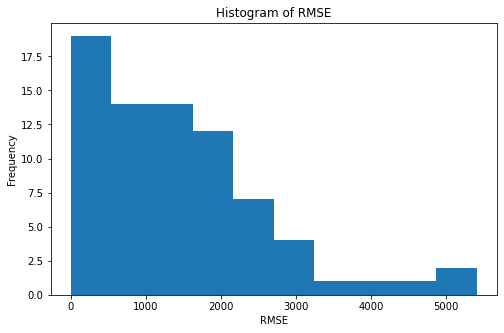

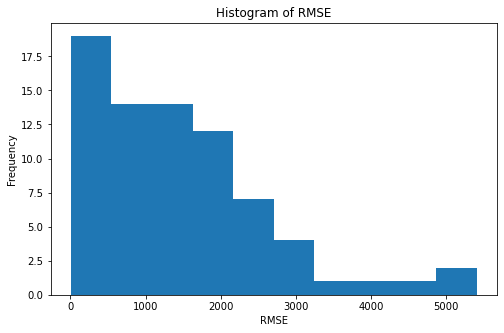

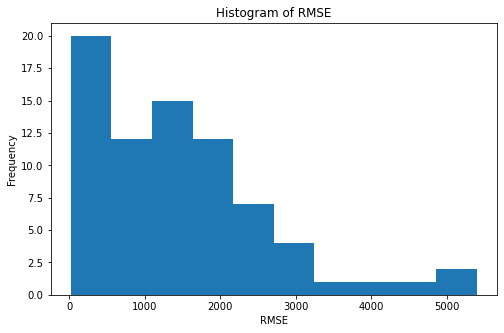

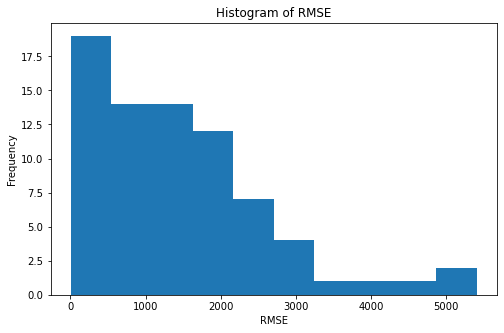

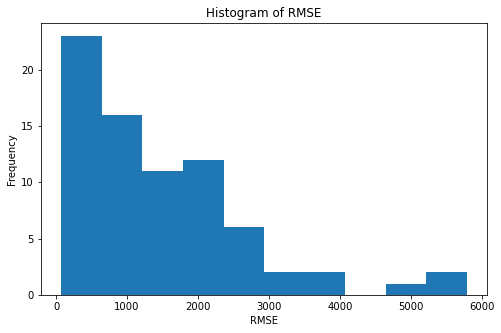

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75


KeyboardInterrupt: 

In [11]:
####Initialize K fold Cross validation
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 42)

#####Grid Space for Lasso, Ridge, ElasticNet
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

####Model Building

model_names = ['OLS', 'Lasso', 'Ridge', 'ElasticNet', 'SVR', 'Lightgbm', 'GBR', 'XGBoost']
models = [linear_model.LinearRegression(), \
            LassoCV(max_iter = int(1e7), alphas = alphas2, random_state = 42, cv = kfolds), \
                  RidgeCV(alphas = alphas_alt, cv = kfolds), \
                  ElasticNetCV(max_iter = int(1e7), alphas = e_alphas, cv = kfolds, l1_ratio = e_l1ratio), \
                  SVR(C = 20, epsilon = 0.008, gamma = 0.0003), \
#                   LGBMRegressor(objective='regression', num_leaves = 4, learning_rate = 0.01, n_estimators = 5000, max_bin = 200, bagging_fraction = 0.75, \
#                                 bagging_freq = 5, bagging_seed = 7, feature_fraction = 0.2, feature_fraction_seed = 7, verbose = -1), \
                  GradientBoostingRegressor(n_estimators = 5000, learning_rate = 0.05, max_depth = 4, max_features = 'sqrt', min_samples_leaf = 15, \
                                            min_samples_split = 10, loss = 'huber', random_state = 42), \
                  XGBRegressor(learning_rate = 0.005, n_estimators = 10000, max_depth = 3, min_child_weight = 0, gamma = 0, subsample = 0.7, \
                               colsample_bytree = 0.7, objective = 'reg:linear', nthread = -1, scale_pos_weight = 1, seed = 27, reg_alpha = 0.00006)
         ]

fitted_models = []
Test_MAE_models = []
Test_RMSE_models = []
Test_R2_models = []
Test_mape_models = []

for model in models:
    fitted_models.append(model.fit(X_train_Yield_kg_per_ha, y_train_Yield_kg_per_ha))
    inv_transform_y_actuals = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(y_test_Yield_kg_per_ha).reshape(-1, 1))
    inv_transformed_preds = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(fitted_models[models.index(model)].predict(X_test_Yield_kg_per_ha).reshape(-1,1)))                                             
    Test_MAE_models.append(mae(inv_transform_y_actuals, inv_transformed_preds))
    Test_RMSE_models.append(rmse(inv_transform_y_actuals, inv_transformed_preds))
    Test_R2_models.append(r2(inv_transform_y_actuals, inv_transformed_preds))
    Test_mape_models.append(mape(inv_transform_y_actuals, inv_transformed_preds))
    plt.figure(figsize = (8,5))
    plt.hist(np.sqrt((inv_transform_y_actuals - inv_transformed_preds)**2))
    plt.xlabel('RMSE')
    plt.ylabel('Frequency')
    plt.title('Histogram of RMSE')
    plt.show()

In [ ]:
for model_name in model_names:
    print(model_name)
    print('MAE on test data: ' + str(Test_MAE_models[model_names.index(model_name)]))
    print('RMSE on test data: ' + str(Test_RMSE_models[model_names.index(model_name)]))
    print('R squared on test data: ' + str(Test_R2_models[model_names.index(model_name)]))
    print('MAPE on test data: ' + str(Test_mape_models[model_names.index(model_name)]))
    inv_transformed_y_actuals = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(y_test_Yield_kg_per_ha).reshape(-1, 1))
    inv_transformed_preds = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(fitted_models[model_names.index(model_name)].predict(X_test_Yield_kg_per_ha).reshape(-1,1)))
    fig, ax = plt.subplots()
    ax.axhline(y=mean_Yield_kg_per_ha, color='r', linestyle='-', label = 'Mean Actual Target = ' + str(int(mean_Yield_kg_per_ha)))
    ax.scatter(inv_transformed_y_actuals, inv_transformed_preds)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('Actual Target')
    plt.ylabel('Predicted Target')
    plt.title(model_name + ' (Target: Yield kg per ha)')
    plt.legend()
    plt.show()

In [ ]:
from sklearn.inspection import permutation_importance

for i in range(len(fitted_models)):
    feature_names = train_Yield_kg_per_ha.drop(columns = ['Yield_kg_per_Ha']).columns

    result = permutation_importance(
        fitted_models[i], X_test_Yield_kg_per_ha, y_test_Yield_kg_per_ha, n_repeats=10, random_state=42, n_jobs=2
    )

    model_importances = pd.Series(result.importances_mean, index = feature_names)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    model_importances.plot.bar(yerr = result.importances_std, ax = ax)
    ax.set_title("Feature importances using permutation on full model (" + str(model_names[i]) + ')')
    ax.set_ylabel("Mean Accuracy decrease")
    plt.grid()
    fig.tight_layout()
    plt.show()

In [95]:
print(df_winter_SOM_cluster_0['Soil_Organic_Matter'].max())
print(df_winter_SOM_cluster_0['Soil_Organic_Matter'].min())
print(df_winter_SOM_cluster_1['Soil_Organic_Matter'].max())
print(df_winter_SOM_cluster_1['Soil_Organic_Matter'].min())
print(str(len(df_winter_SOM_cluster_0['Soil_Organic_Matter']) / len(df_winter_SOM_cluster_1['Soil_Organic_Matter'])))

5.746666666666667
3.0529411764705885
3.0125
0.4
0.19518716577540107
